# Trial by trial variability analysis

**11th March 2024 (edited the 6th of May 2024)**

*Théo Gauvrit & Célien Vandromme*

---

## Modules and data import

In [47]:
import numpy as np
import pandas as pd
import percephone.core.recording as pc
import os
import percephone.plts.behavior as pbh
import percephone.plts.stats as st
import matplotlib
import percephone.plts.stats as ppt
import matplotlib.pyplot as plt
import percephone.analysis.mlr_models as mlr_m
from multiprocessing import Pool, cpu_count, pool
from sklearn.metrics.pairwise import cosine_similarity
from percephone.analysis.utils import neuron_mean_std_corr, get_iter_range, get_timepoints

plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline

In [48]:
user = "Théo"

if user == "Célien":
    directory = "C:/Users/cvandromme/Desktop/Data/"
    roi_path = "C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx"
elif user == "Théo":
    directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
    roi_path = directory + "/FmKO_ROIs&inhibitory.xlsx"
    
roi_info = pd.read_excel(roi_path)
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil, i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, roi_path)
    rec.peak_delay_amp()
    return rec

workers = cpu_count()
if user == "Célien":
    pool = pool.ThreadPool(processes=workers)
elif user == "Théo":
    pool = Pool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file, i)) for i, file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorpor

## Functions used

Function that will generate the cosine similarity matrix

In [49]:
def cosine_matrix(ax, rec, amplitude, resp_mat, divider=None):
    print("Cosine similarity computation")

    sim_mat = cosine_similarity(resp_mat)
    ax.imshow(sim_mat, cmap="seismic", vmin=-1, vmax=+1, interpolation="none", extent=[0, resp_mat.shape[0], 0, resp_mat.shape[0]])
    ax.set_xlabel("Trial i")
    ax.set_ylabel("Trial j")
    ax.set_title(str(rec.filename) + " " + rec.genotype + " " + str(amplitude))
    ax.grid(False)
    if divider is not None:
        ax.vlines(x=divider, ymin=0, ymax=resp_mat.shape[0], colors='k')
        ax.hlines(y=divider, xmin=0, xmax=resp_mat.shape[0], colors='k')

Functions used to estimate the zscore during stimulation time

In [50]:
def get_zscore_dff(rec, exc_neurons=True, inh_neurons=False, dff=False):
    if dff:
        exc = rec.df_f_exc
        inh = rec.df_f_inh
    else:
        exc = rec.zscore_exc
        inh = rec.zscore_inh
        
    if exc_neurons and inh_neurons:
        data = np.row_stack((exc, inh)).T
    elif exc_neurons:
        data = exc.T
    elif inh_neurons:
        data = inh.T
    return data

def get_zscore_estimator(rec, estimator, exc_neurons=True, inh_neurons=True, time_span="stim", window=0.5, dff=False):
    zscore = get_zscore_dff(rec, exc_neurons=exc_neurons, inh_neurons=inh_neurons, dff=dff)
    first = True
    for i in range(get_iter_range(rec, time_span)):
        start, end = get_timepoints(rec, i, time_span, window=window)
        if first:
            X = neuron_mean_std_corr(zscore[start : end], estimator)
            first = False
        else:
            new_row = neuron_mean_std_corr(zscore[start : end], estimator)
            X = np.row_stack((X, new_row))
    return X

The function used to plot the cosine similarity

In [51]:
def plot_cosine_similarity(recs, parameter, estimator=None, 
                           exc_neurons=True, inh_neurons=False, 
                           time_span="stim", window=0.5,
                           detected_trials=True, undetected_trials=True, det_sorting=False, stim_ampl="all"):
    y, i = 0, 0
    fig, ax = plt.subplots(4, 9, figsize=(35, 20))
    
    for rec in recs.values():
        # Filtering stimulation amplitudes
        stim_filter = rec.stim_ampl_filter(stim_ampl)
        
        # Retrieving data for specified parameter and neuron type
        if parameter == "zscore" or parameter == "dff":
            if parameter == "zscore":
                para_mat = get_zscore_estimator(rec, estimator, exc_neurons=exc_neurons, inh_neurons=inh_neurons, time_span=time_span, window=window, dff=False).T
            else:
                para_mat = get_zscore_estimator(rec, estimator, exc_neurons=exc_neurons, inh_neurons=inh_neurons, time_span=time_span, window=window, dff=True).T
            neuron_type = "EXC & INH" if (exc_neurons and inh_neurons) else ("EXC" if exc_neurons else ("INH" if inh_neurons else "NONE"))
        else:
            # Filtering neuron type
            if exc_neurons and inh_neurons: 
                para_mat = np.row_stack((rec.matrices["EXC"][parameter], rec.matrices["INH"][parameter]))
                neuron_type = "EXC & INH"
            elif exc_neurons:
                para_mat = rec.matrices["EXC"][parameter]
                neuron_type = "EXC"
            elif inh_neurons:
                para_mat = rec.matrices["INH"][parameter]
                neuron_type = "INH"
        
        # Filtering detected trials and amplitudes
        divider = None
        if detected_trials and undetected_trials:
            if det_sorting:
                filt_para_mat = np.row_stack((para_mat.T[np.logical_and(rec.detected_stim, stim_filter)], para_mat.T[np.logical_and(np.invert(rec.detected_stim), stim_filter)]))
                trials_type = "all (sorted)"
                divider = np.logical_and(rec.detected_stim, stim_filter).sum()
            else:
                filt_para_mat = para_mat.T[stim_filter]
                trials_type = "all"
        elif detected_trials:
            filt_para_mat = para_mat.T[np.logical_and(rec.detected_stim, stim_filter)]
            trials_type = "detected"
        elif undetected_trials:
            filt_para_mat = para_mat.T[np.logical_and(np.invert(rec.detected_stim), stim_filter)]
            trials_type = "undetected"
        
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            cosine_matrix(ax[1, i], rec, rec.threshold, filt_para_mat, divider=divider)
            i = i + 1
        elif rec.genotype == "KO-Hypo":
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            cosine_matrix(ax[3, y], rec, rec.threshold, filt_para_mat, divider=divider)
            y = y + 1
    
    # Hiding the empty graphs
    ax[2, 7].set_axis_off()
    ax[2, 8].set_axis_off()
    ax[3, 7].set_axis_off()
    ax[3, 8].set_axis_off()
    if parameter == "zscore":
        fig.suptitle(f"Cosine similarity based on {estimator} {parameter} for {trials_type} trials in {neuron_type} neurons. Amplitude(s): {stim_ampl}", fontsize=26)
    else:
        fig.suptitle(f"Cosine similarity based on {parameter} for {trials_type} trials in {neuron_type} neurons. Amplitude(s): {stim_ampl}", fontsize=26)

# Cosine similarity based on responsivity

---

## All amplitudes

### All trials

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


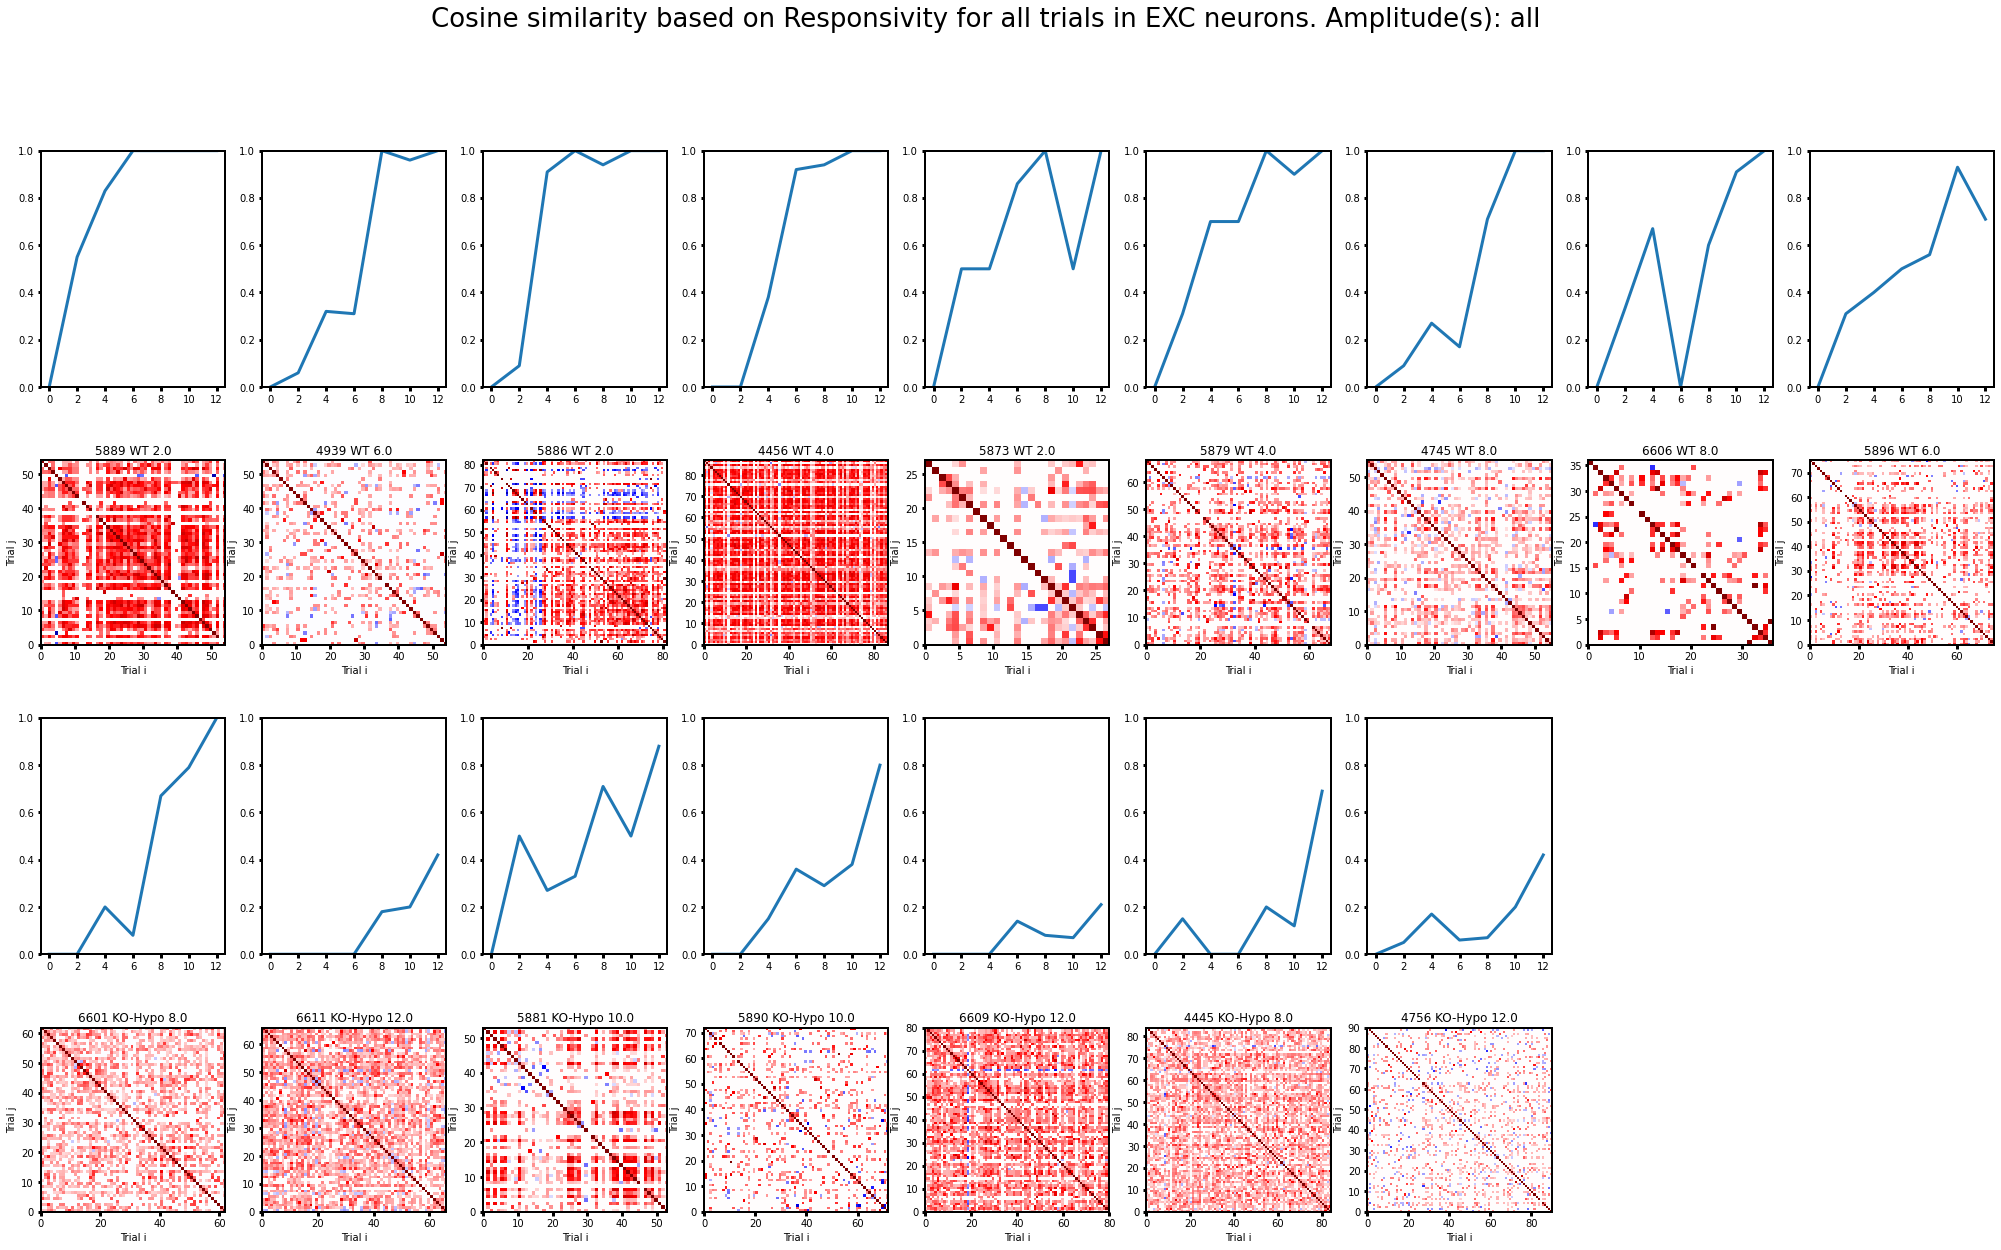

In [52]:
plot_cosine_similarity(recs, "Responsivity", estimator=None, exc_neurons=True, inh_neurons=False, detected_trials=True, undetected_trials=True, stim_ampl="all")

### Detected trials

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


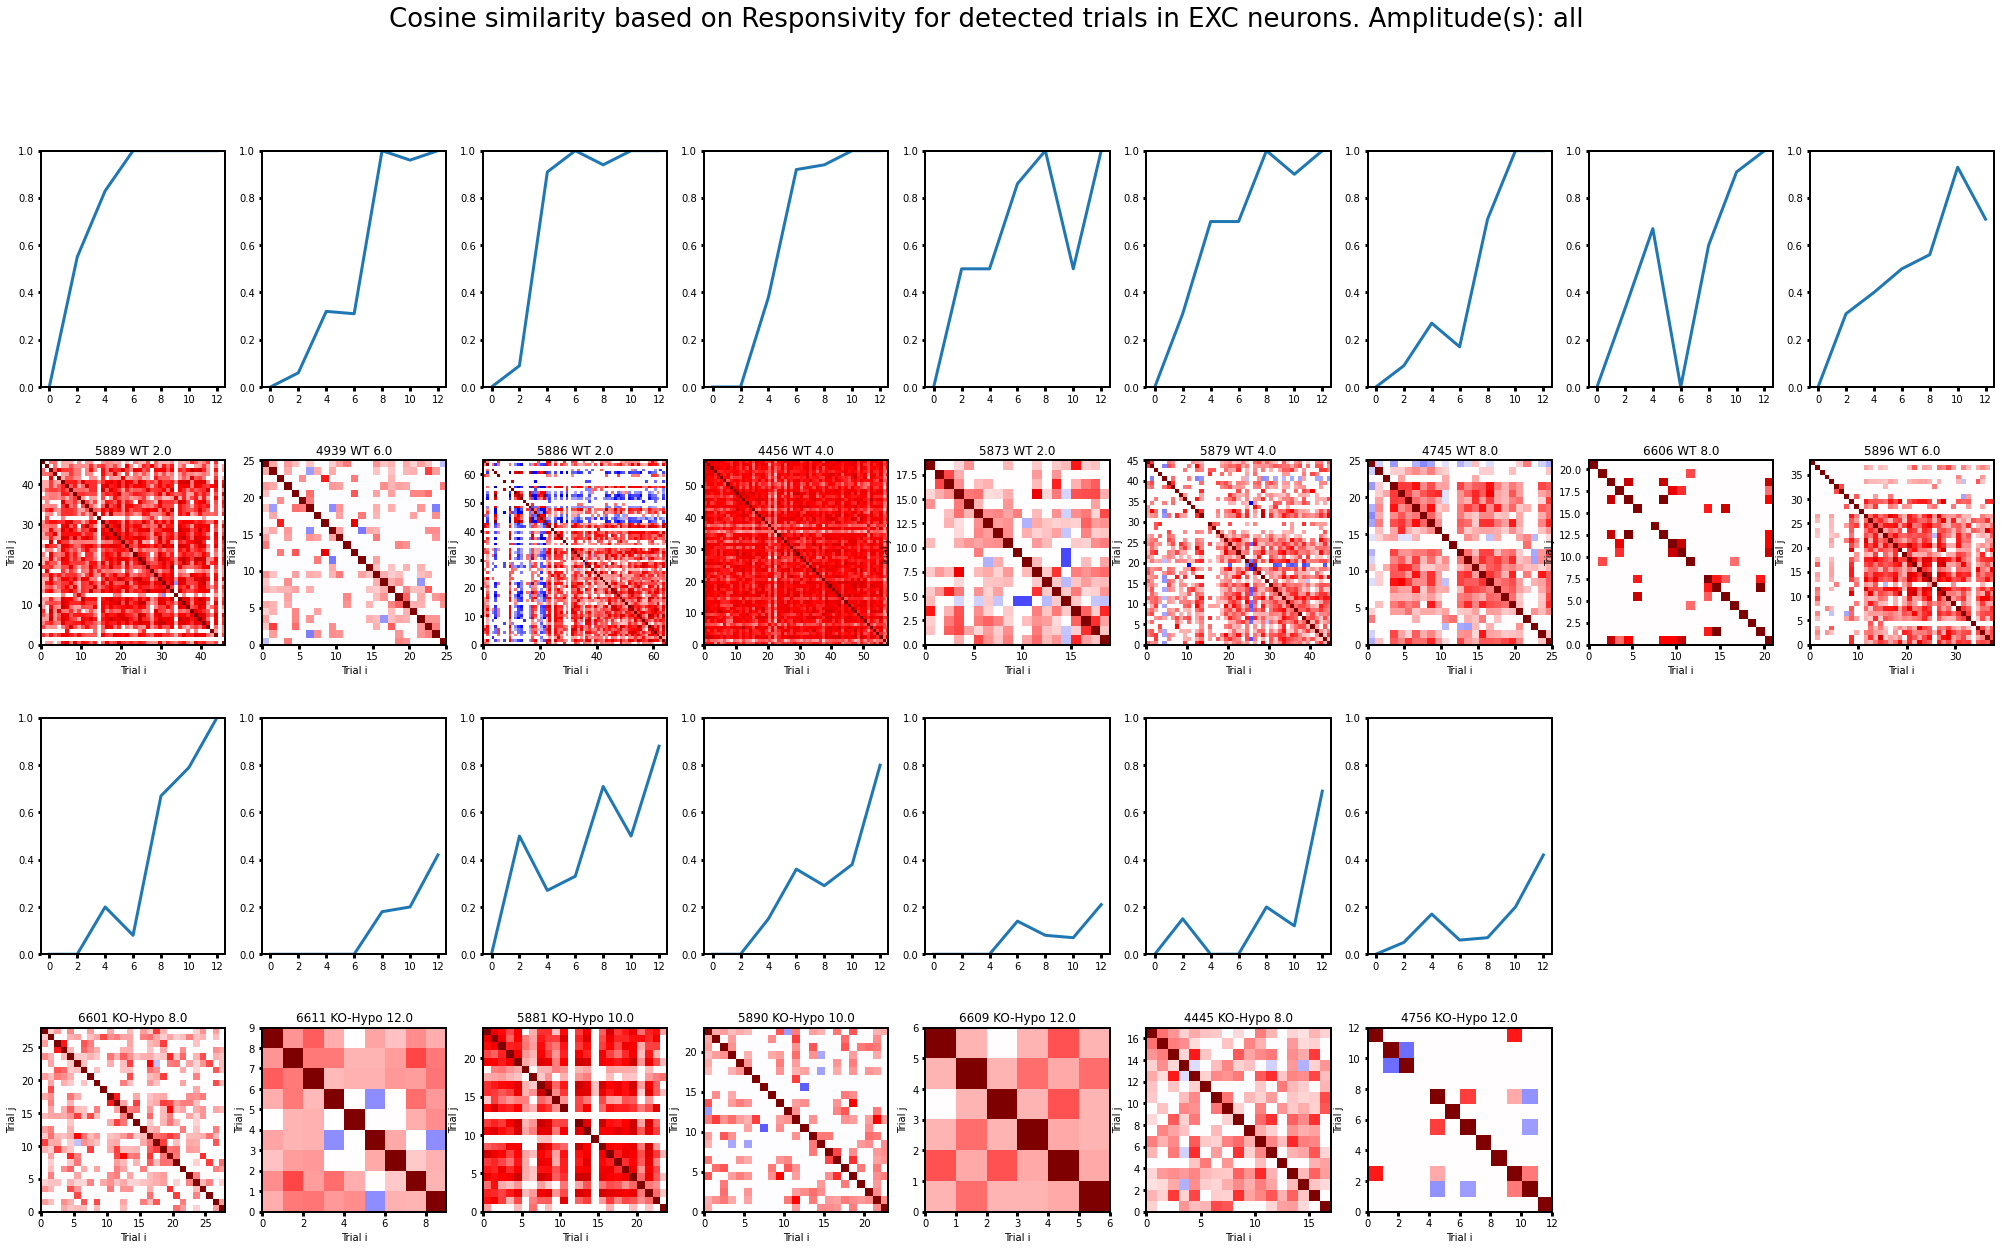

In [53]:
plot_cosine_similarity(recs, "Responsivity", estimator=None, exc_neurons=True, inh_neurons=False, detected_trials=True, undetected_trials=False, stim_ampl="all")

### Undetected trials

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


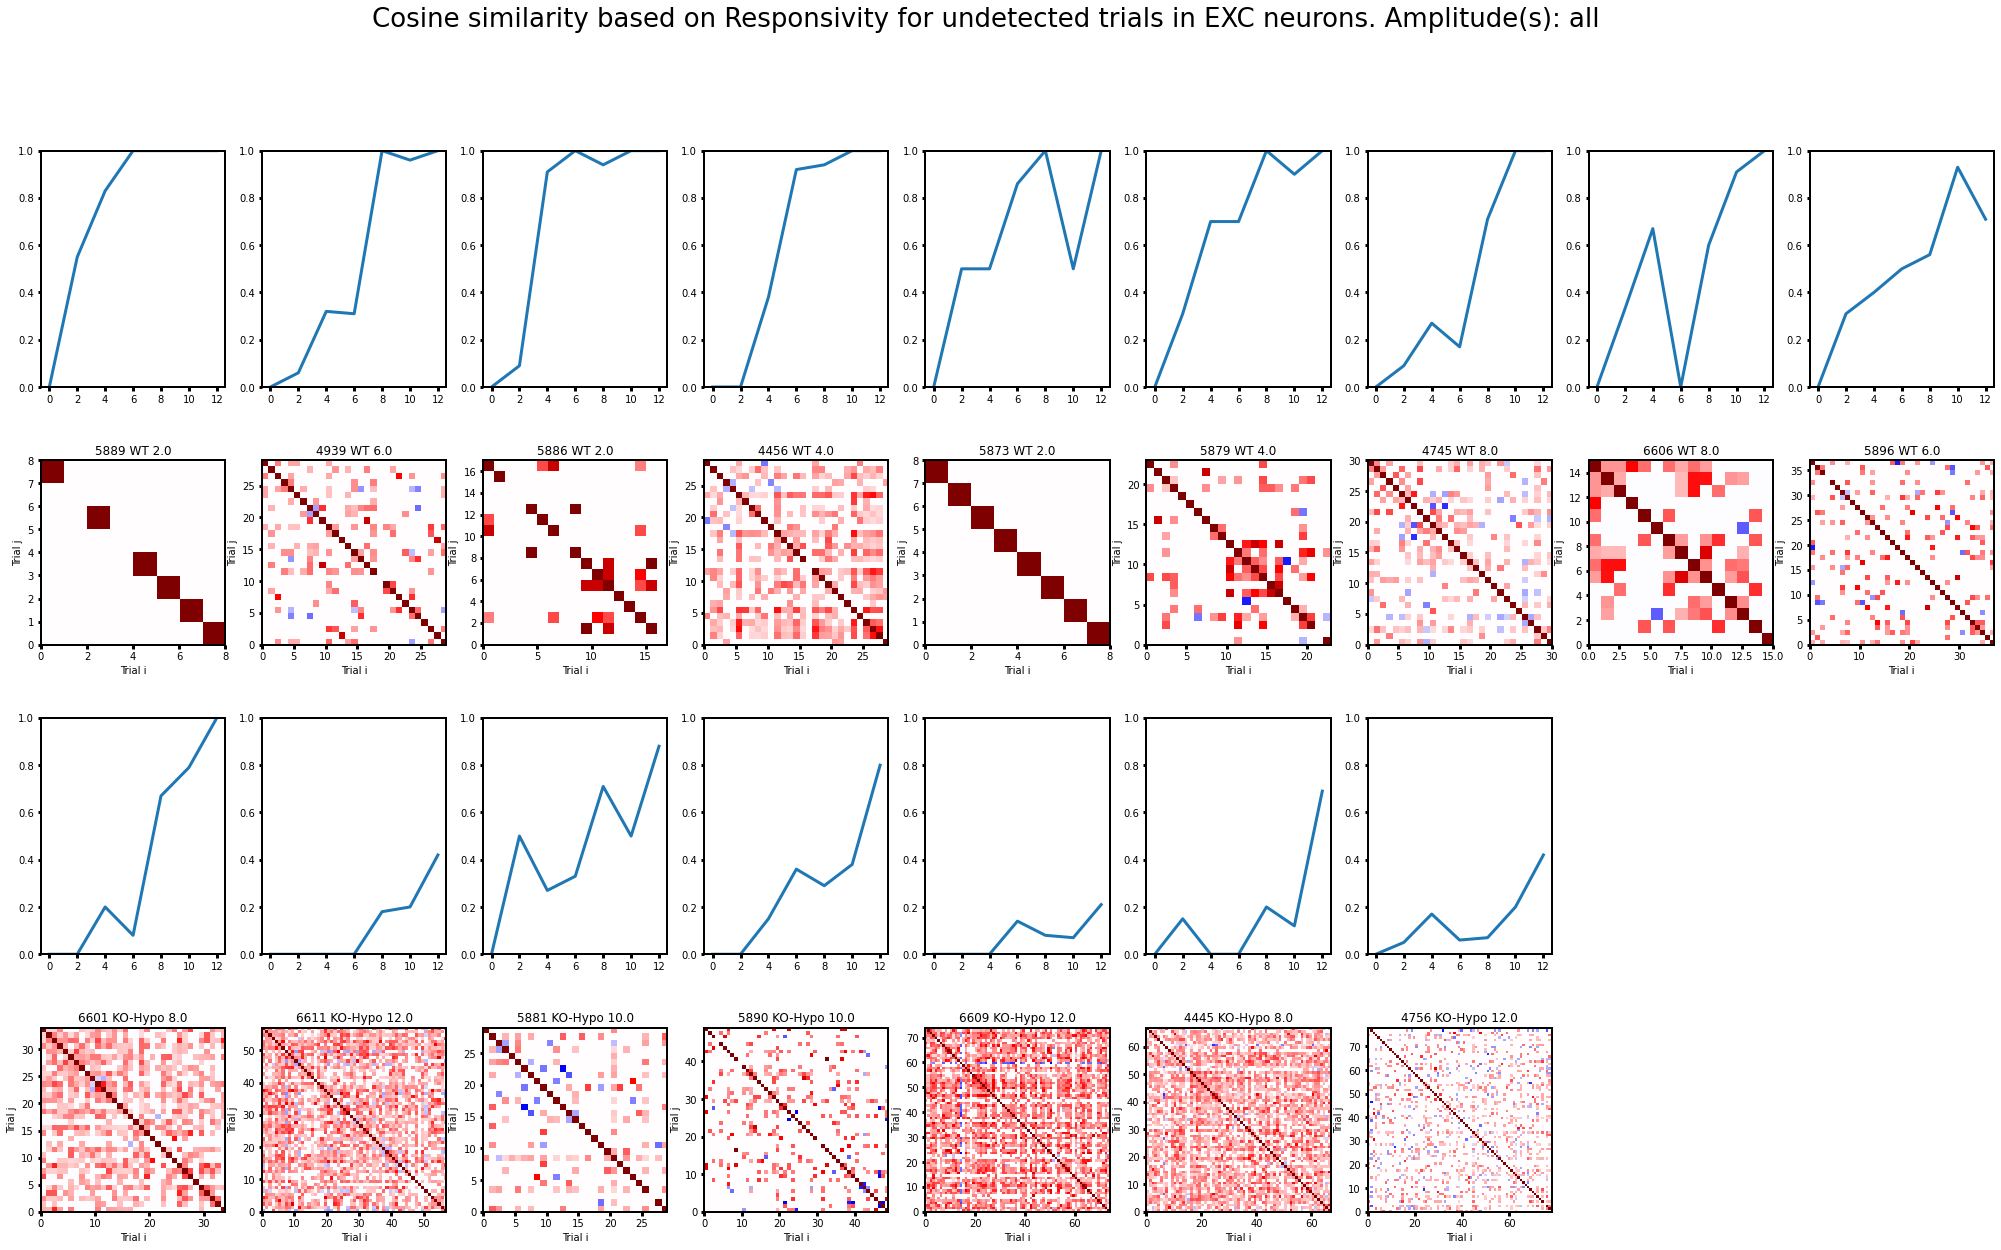

In [54]:
plot_cosine_similarity(recs, "Responsivity", estimator=None, exc_neurons=True, inh_neurons=False, detected_trials=False, undetected_trials=True, stim_ampl="all")

## Threshold amplitude

### All trials

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


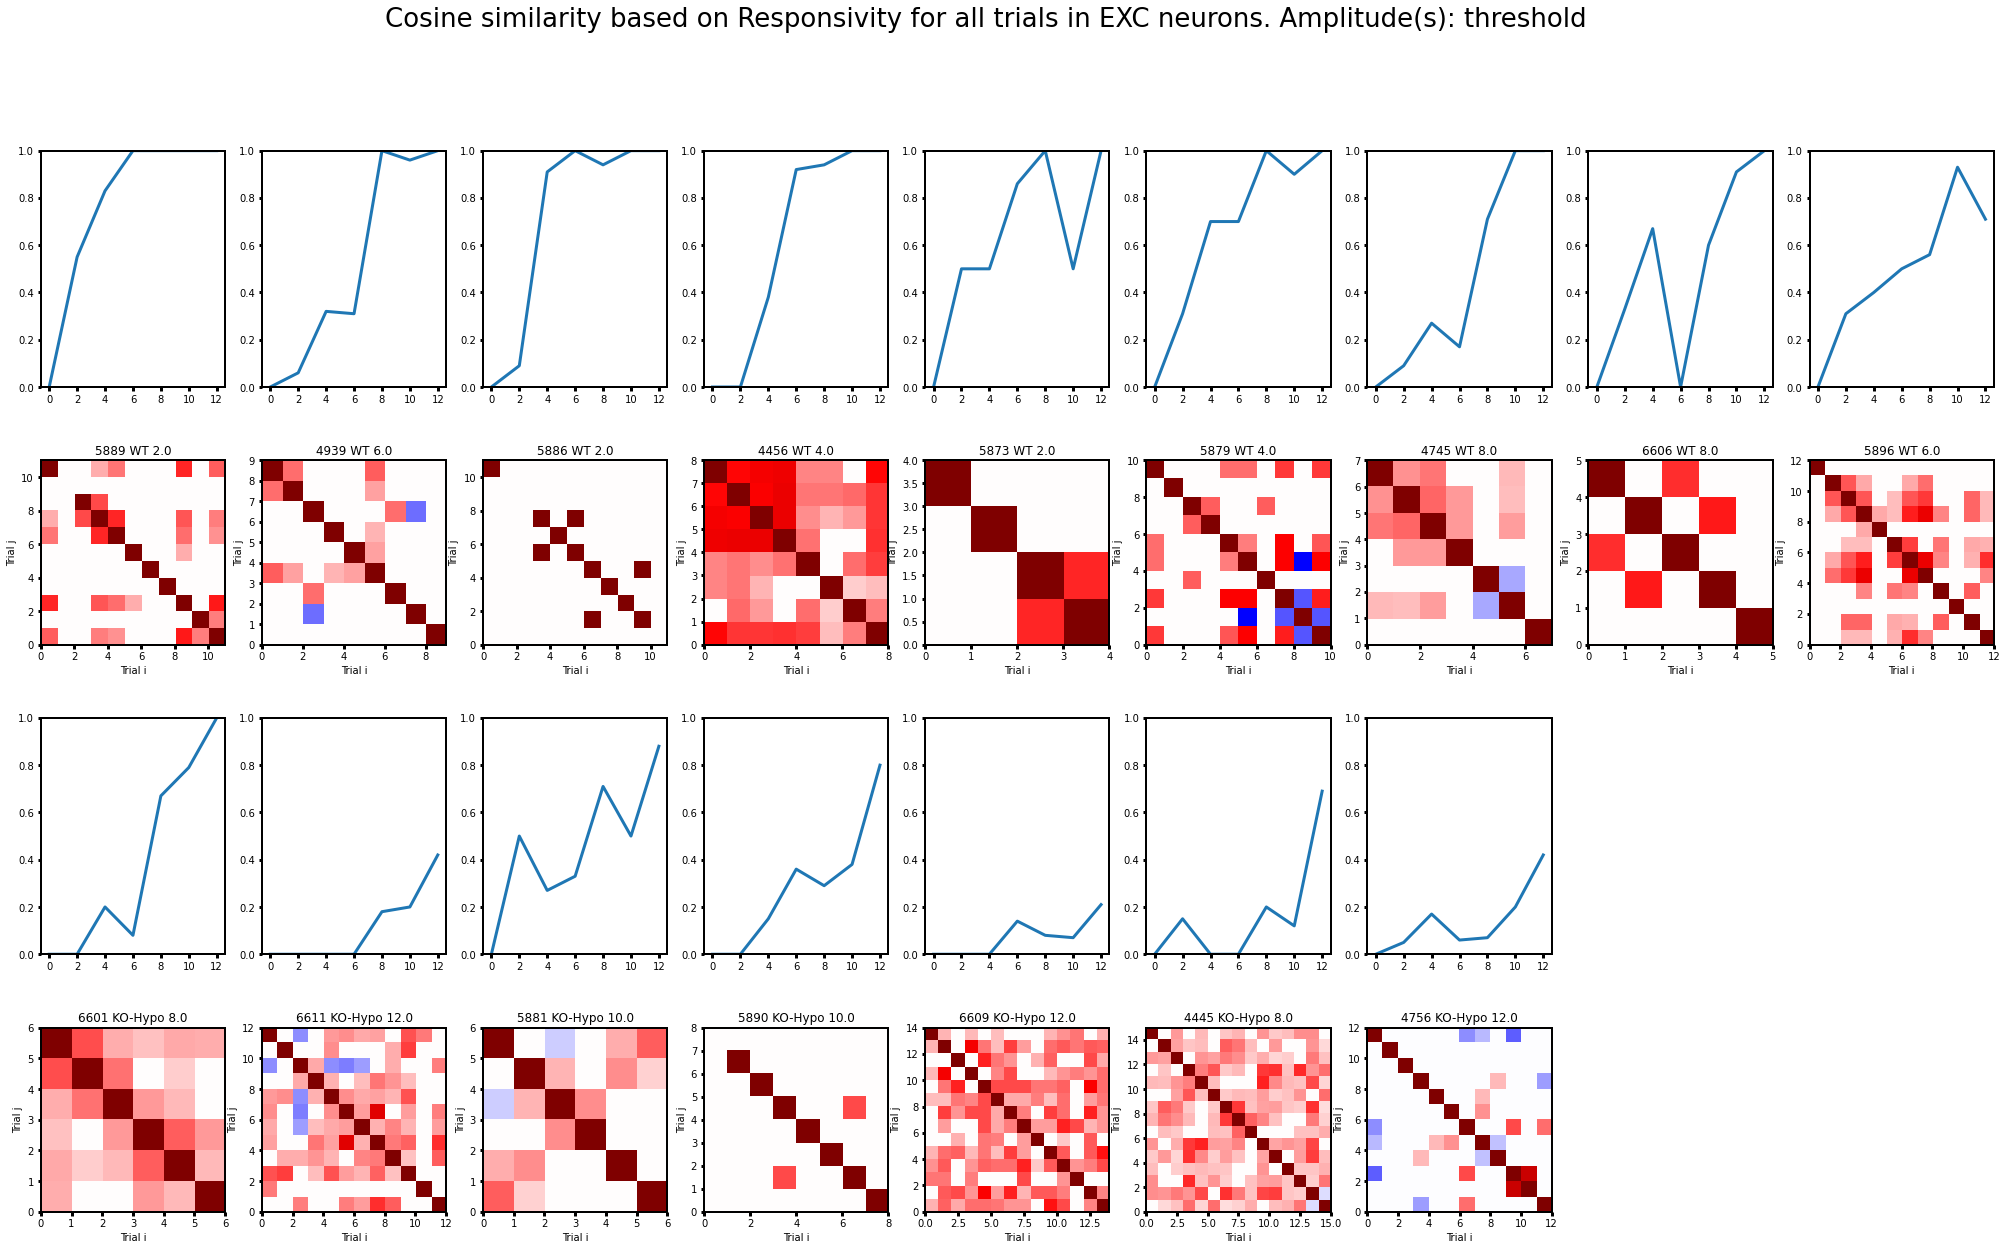

In [55]:
plot_cosine_similarity(recs, "Responsivity", estimator=None, exc_neurons=True, inh_neurons=False, detected_trials=True, undetected_trials=True, stim_ampl="threshold")

### Detected trials

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


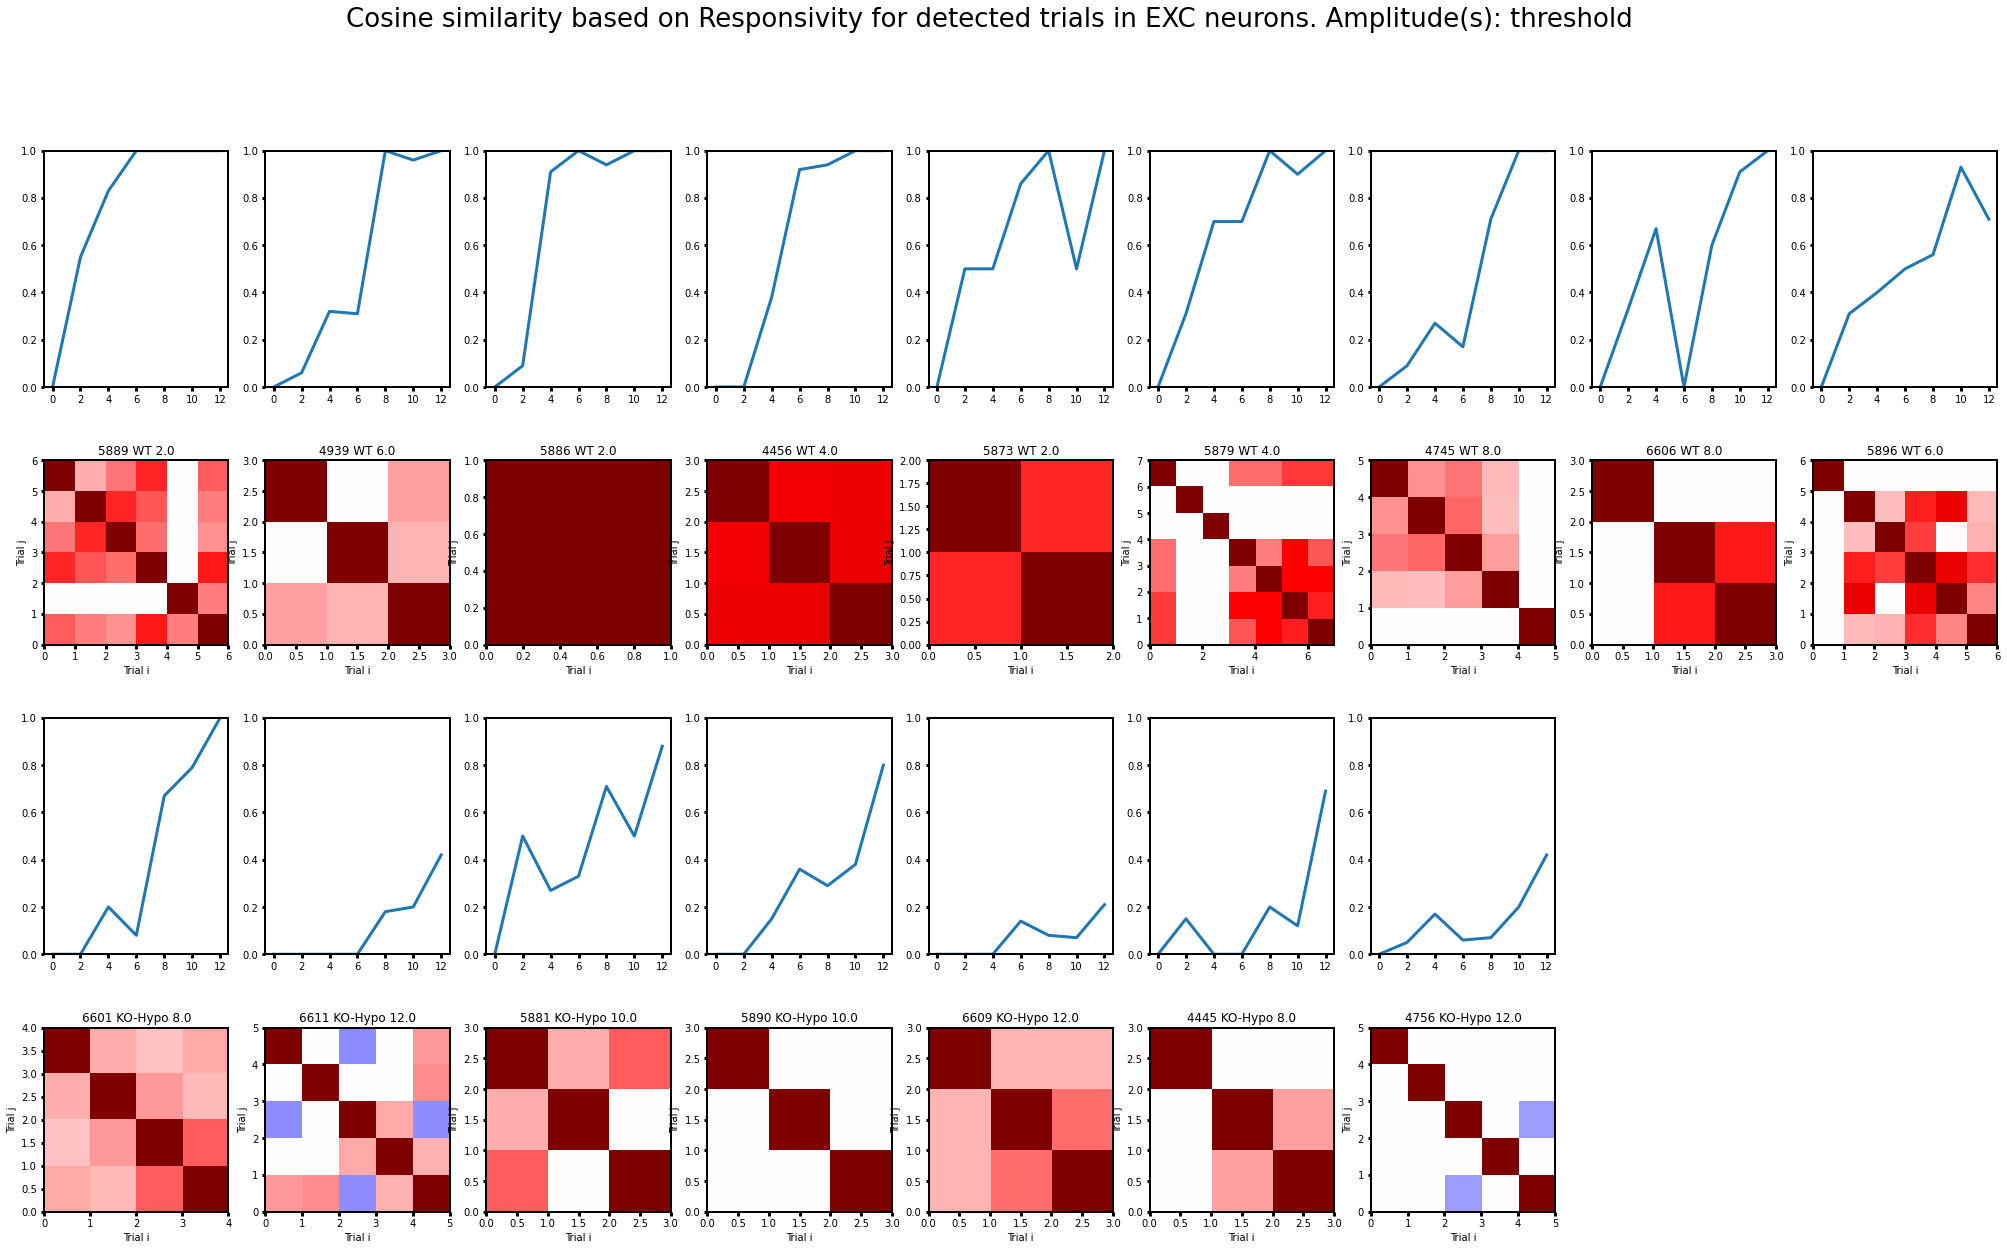

In [56]:
plot_cosine_similarity(recs, "Responsivity", estimator=None, exc_neurons=True, inh_neurons=False, detected_trials=True, undetected_trials=False, stim_ampl="threshold")

### Undetected trials

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


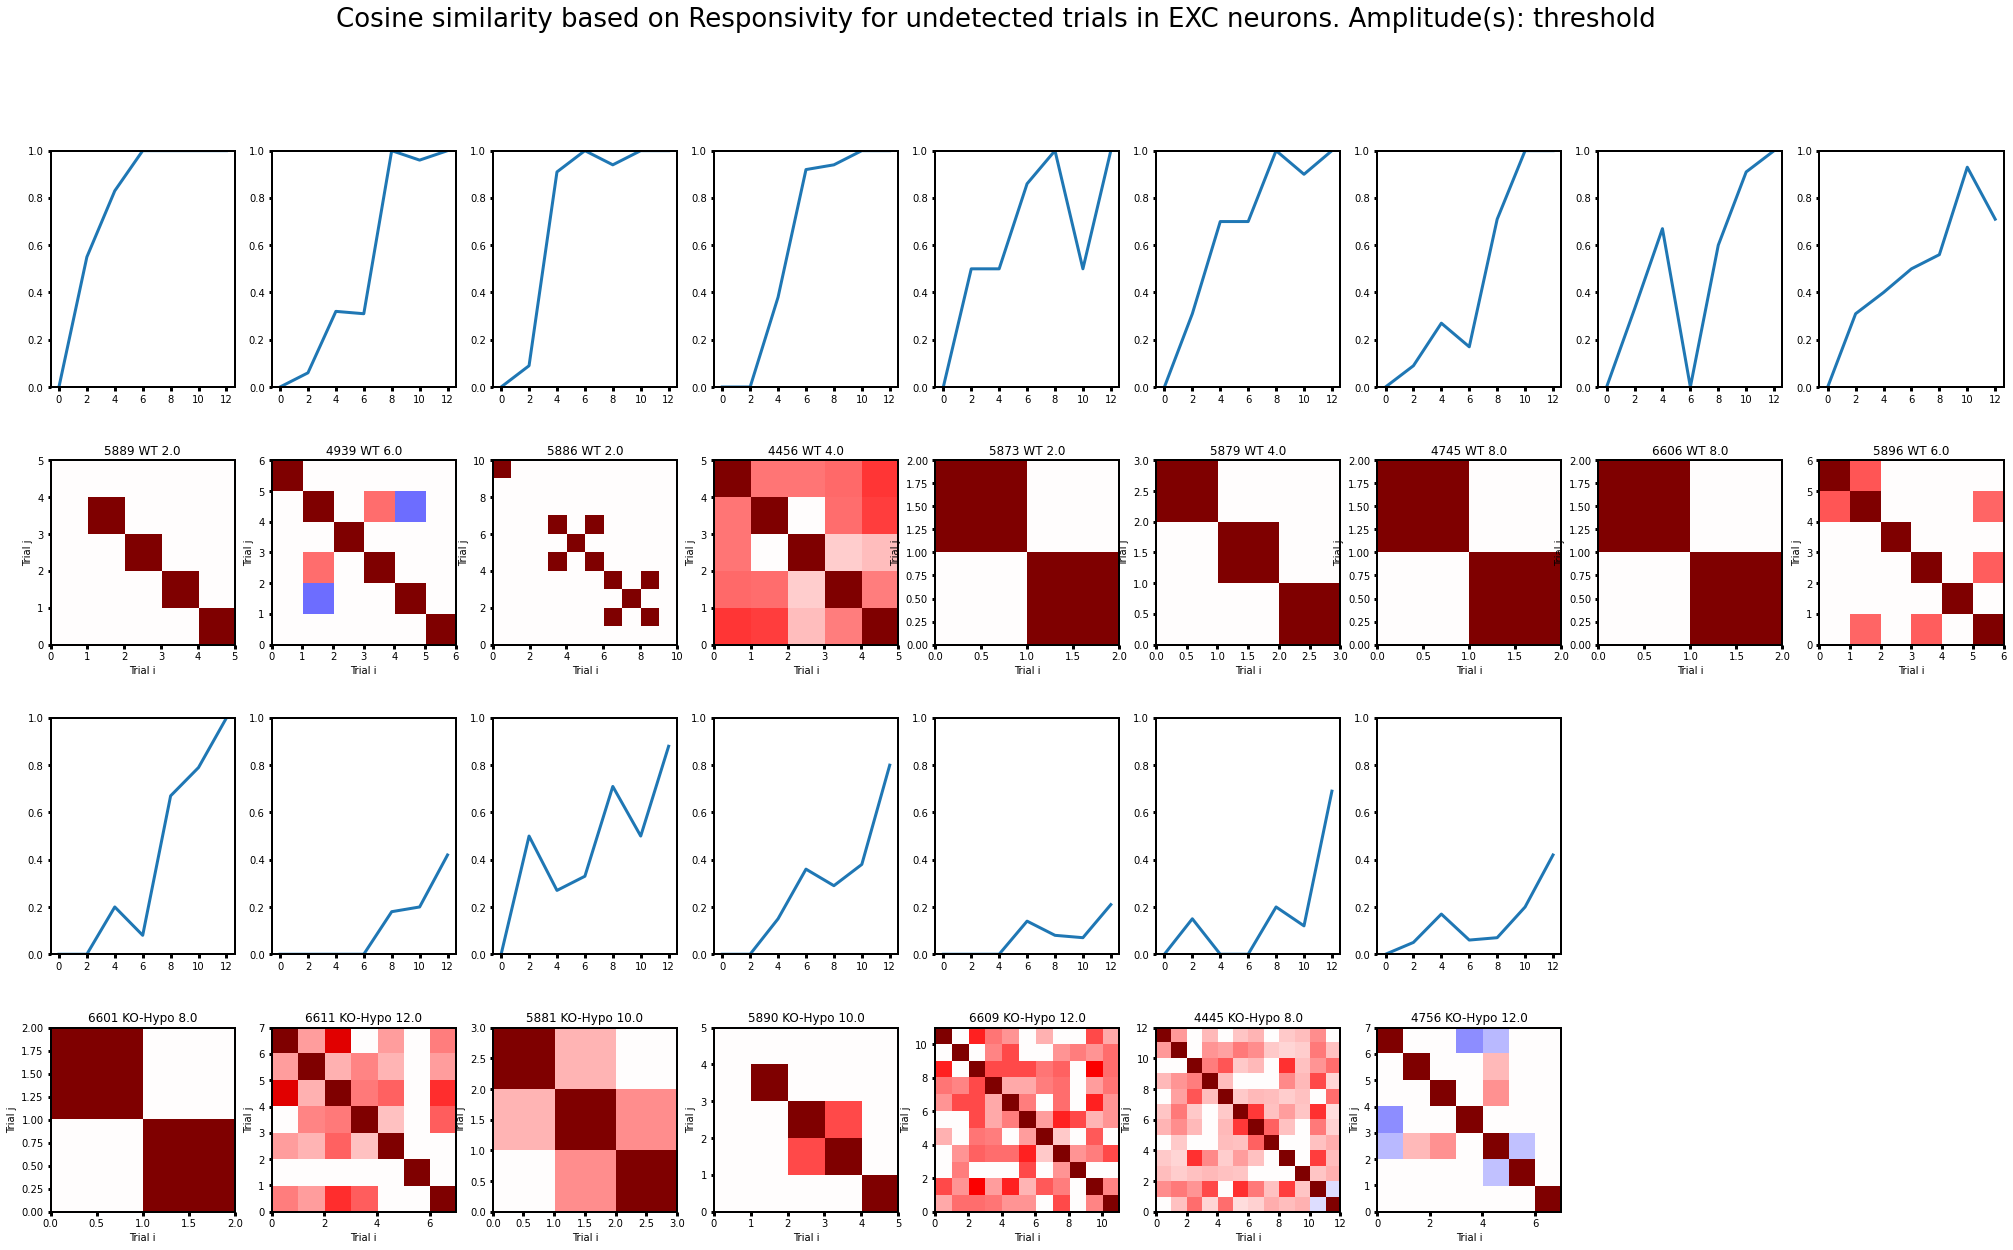

In [57]:
plot_cosine_similarity(recs, "Responsivity", estimator=None, exc_neurons=True, inh_neurons=False, detected_trials=False, undetected_trials=True, stim_ampl="threshold")

# Cosine similarity based on mean zscore

---

## All amplitudes

### All trials

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


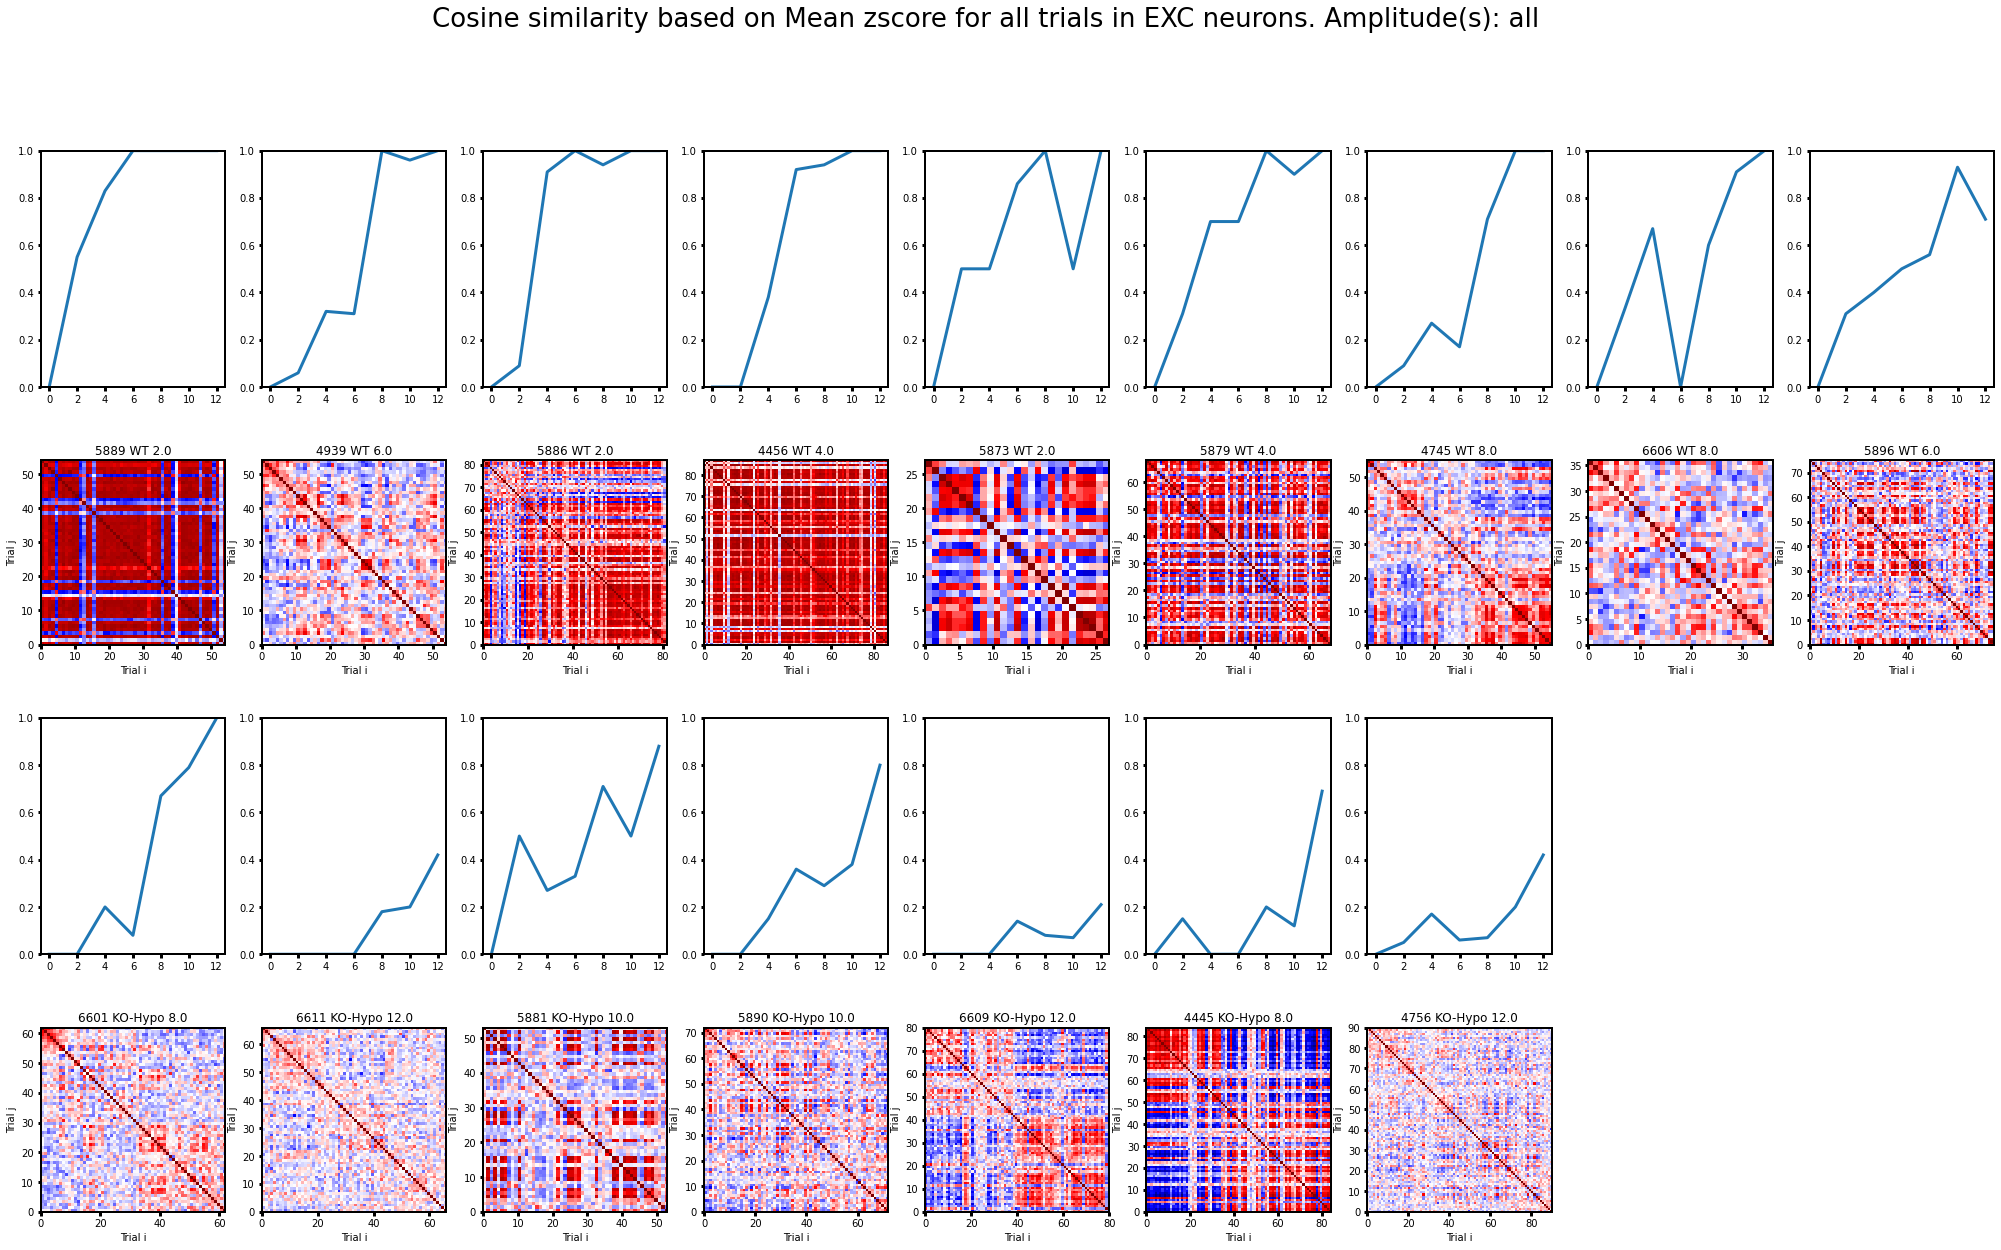

In [58]:
plot_cosine_similarity(recs, "zscore", estimator="Mean", exc_neurons=True, inh_neurons=False, detected_trials=True, undetected_trials=True, stim_ampl="all")

### Detected trials

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


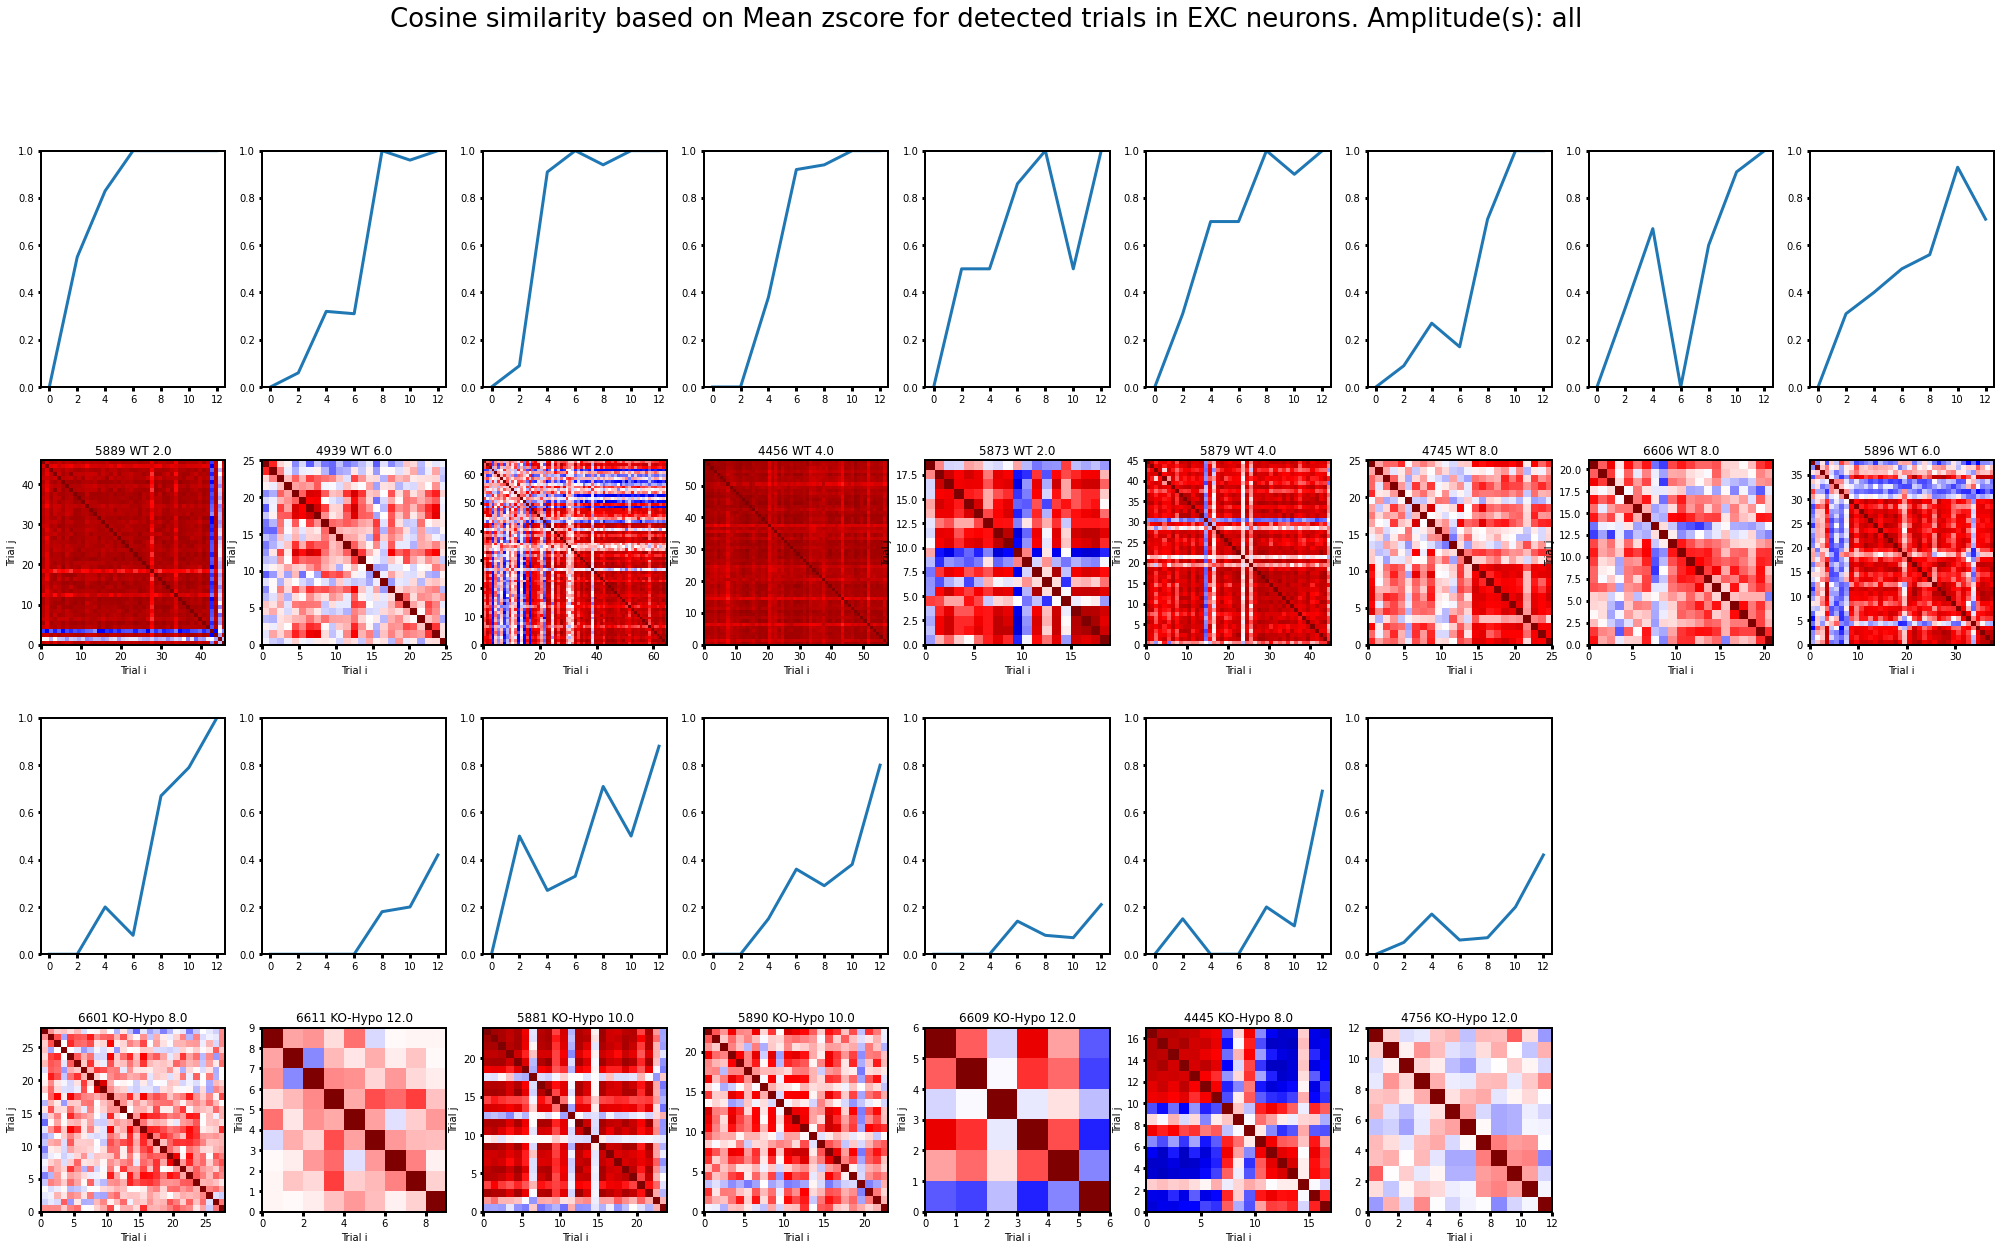

In [59]:
plot_cosine_similarity(recs, "zscore", estimator="Mean", exc_neurons=True, inh_neurons=False, detected_trials=True, undetected_trials=False, stim_ampl="all")

### Undetected trials

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


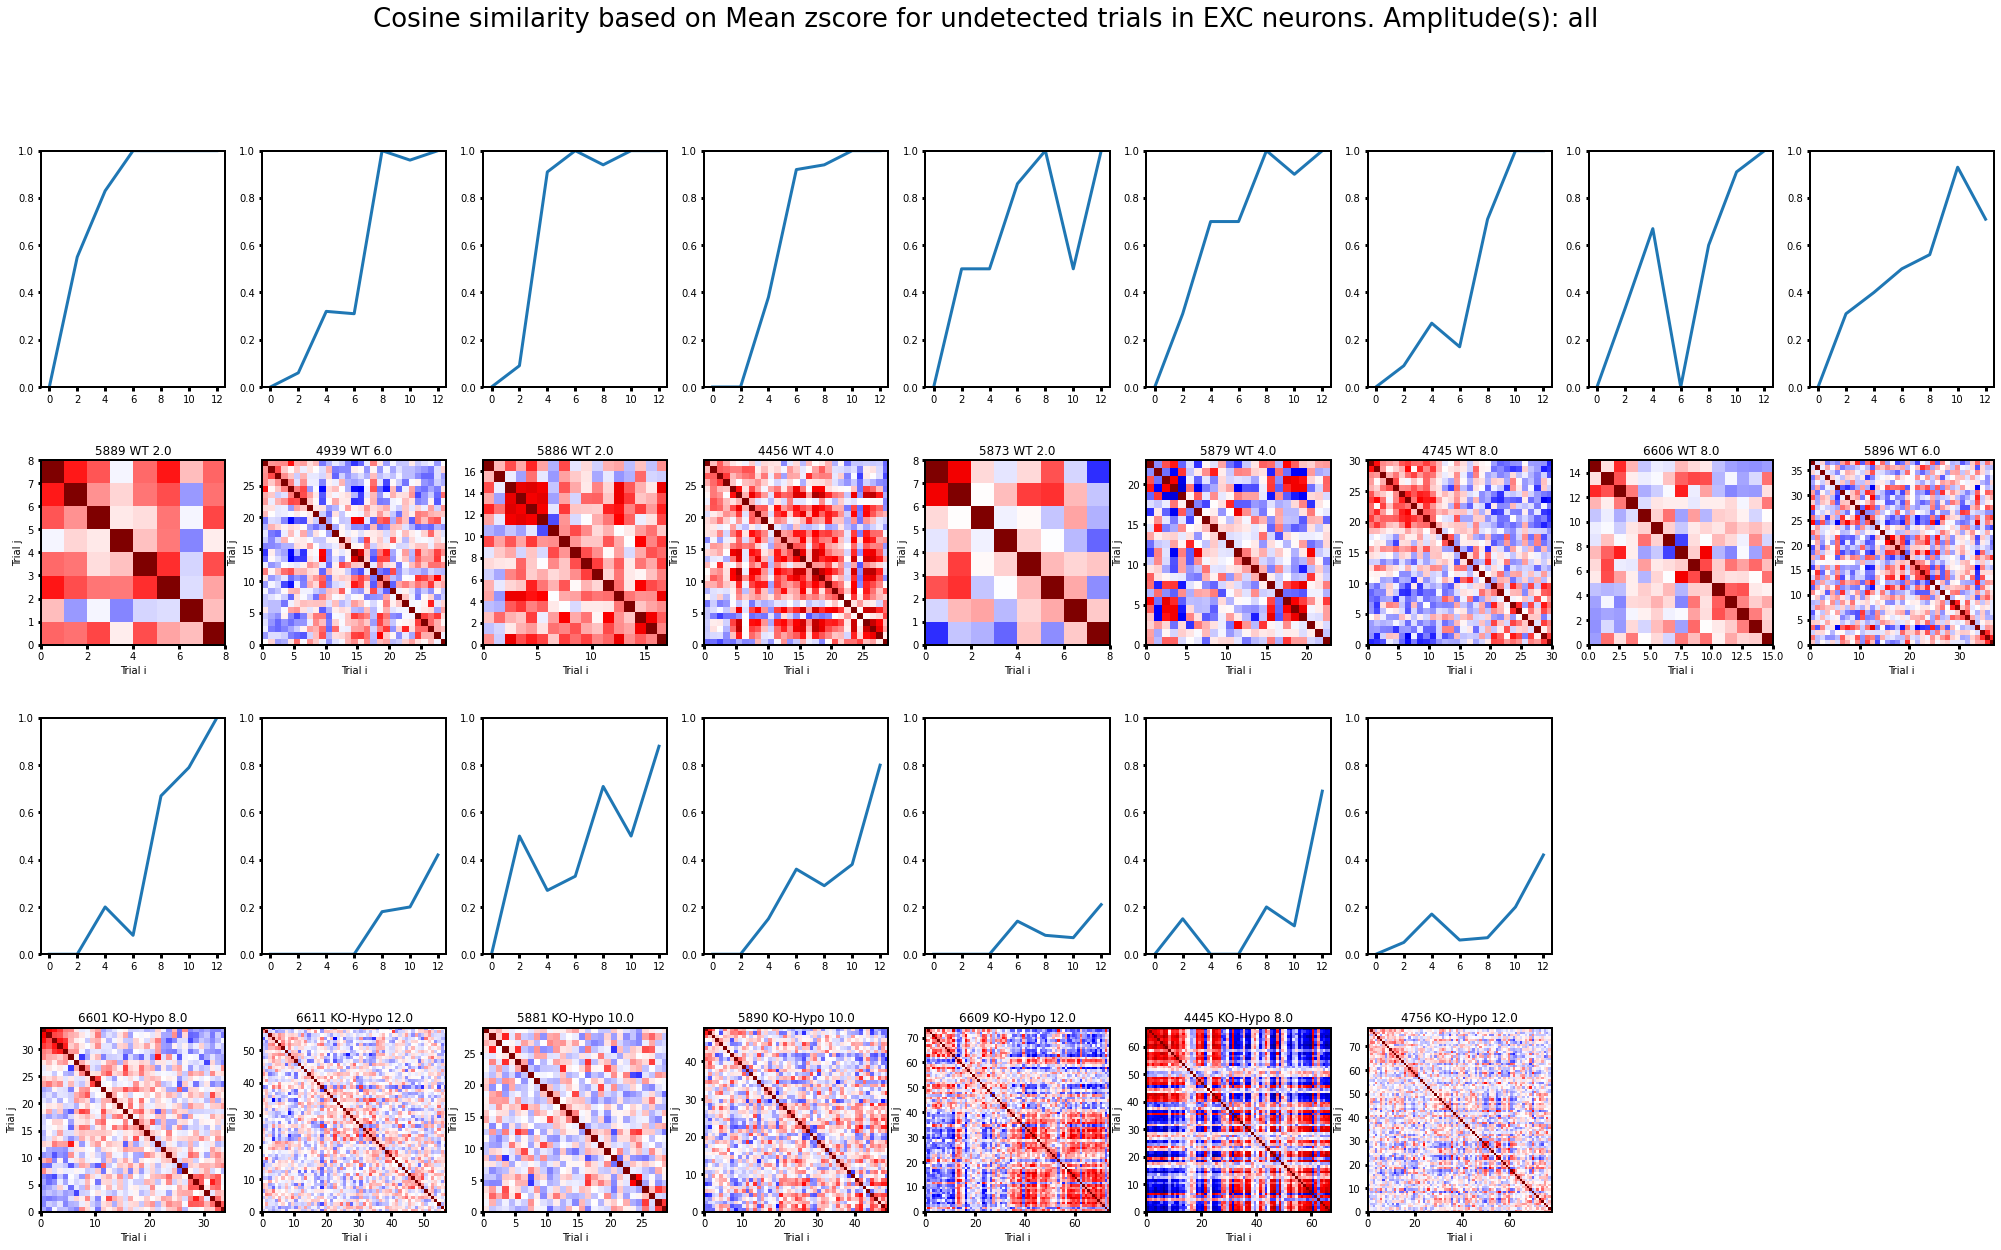

In [60]:
plot_cosine_similarity(recs, "zscore", estimator="Mean", exc_neurons=True, inh_neurons=False, detected_trials=False, undetected_trials=True, stim_ampl="all")

## Threshold amplitude

### All trials

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


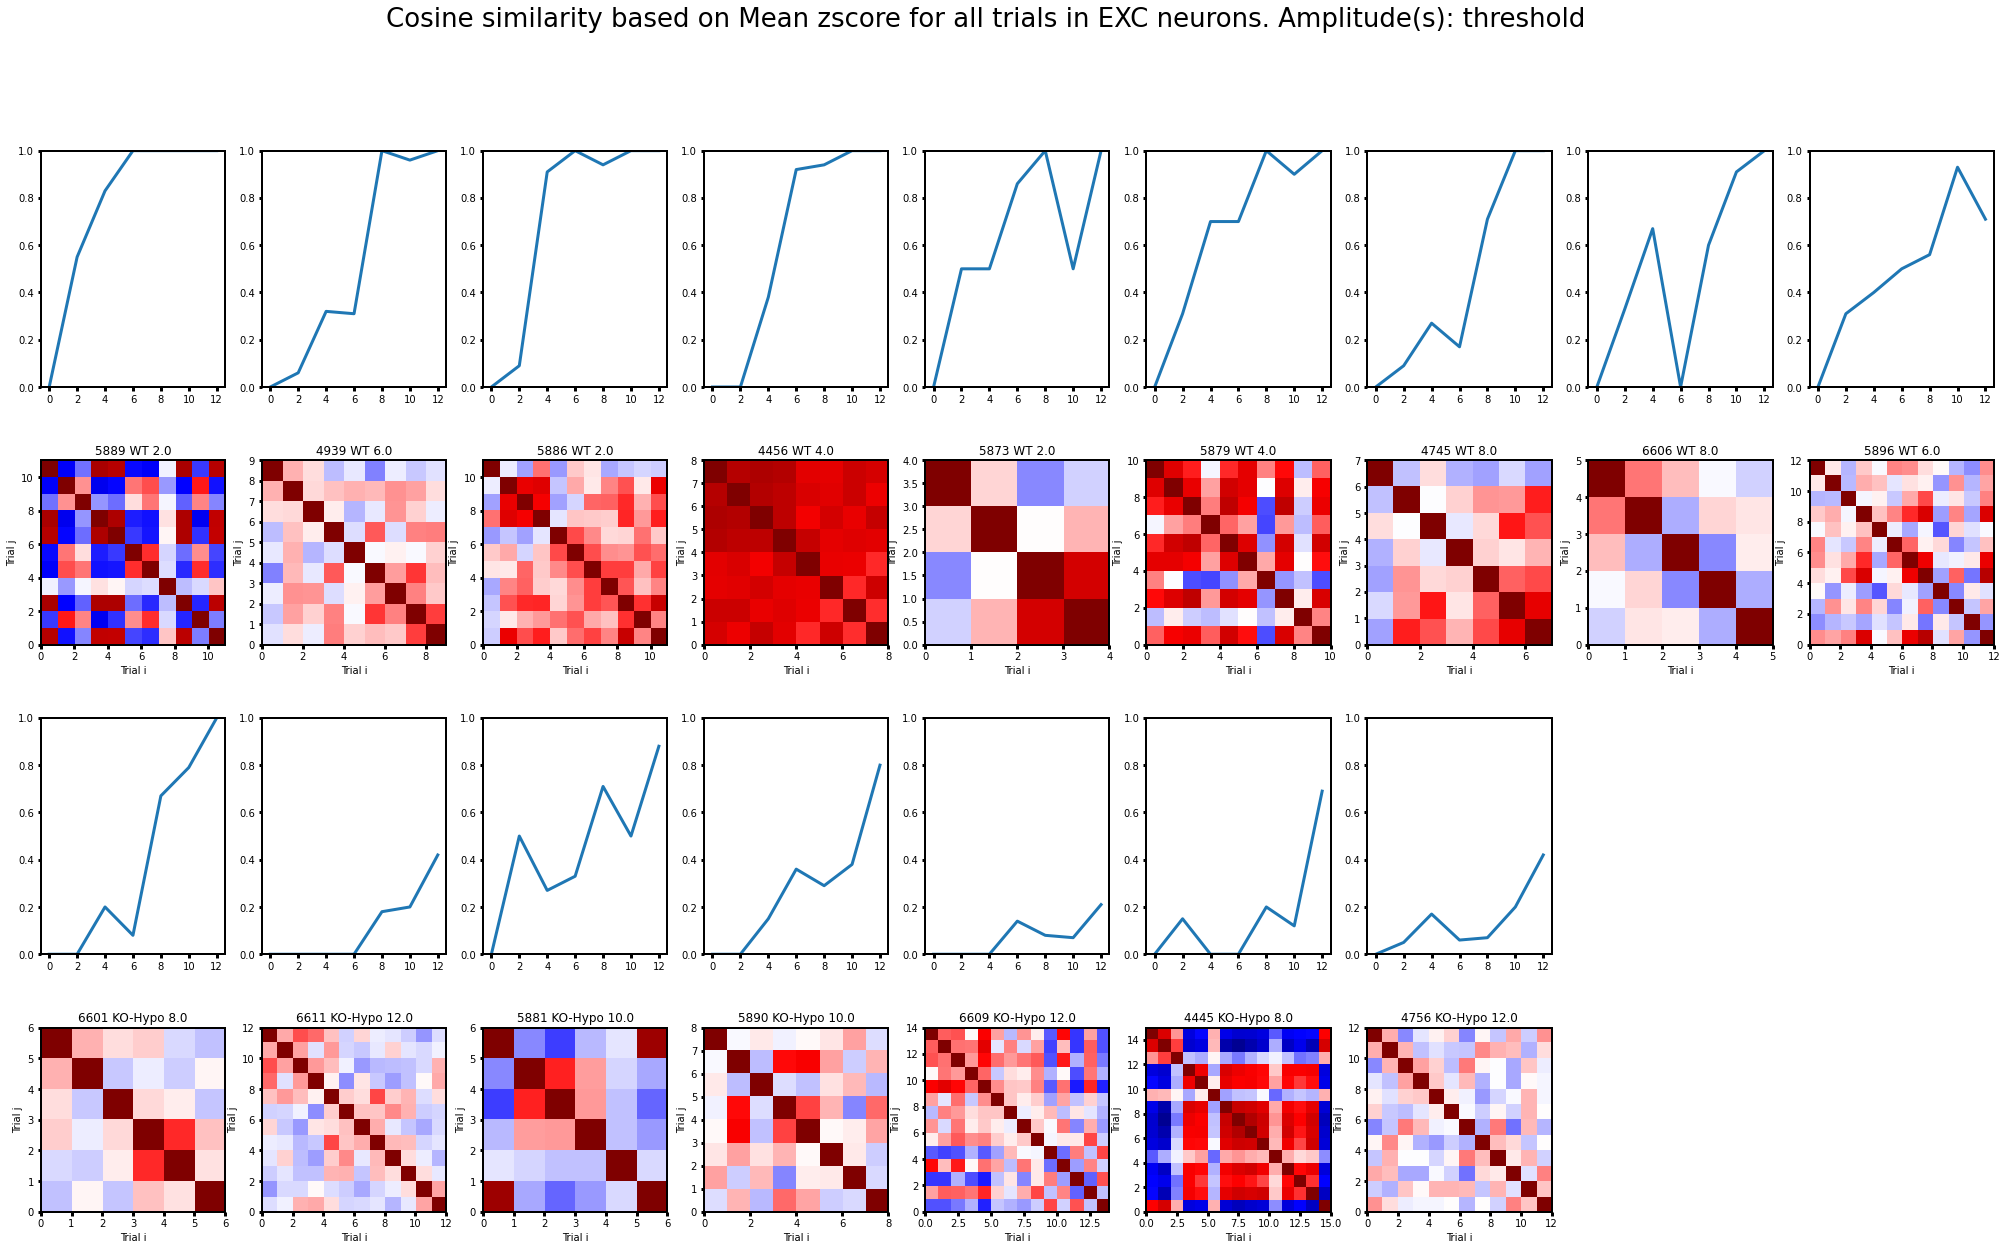

In [61]:
plot_cosine_similarity(recs, "zscore", estimator="Mean", exc_neurons=True, inh_neurons=False, detected_trials=True, undetected_trials=True, stim_ampl="threshold")

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


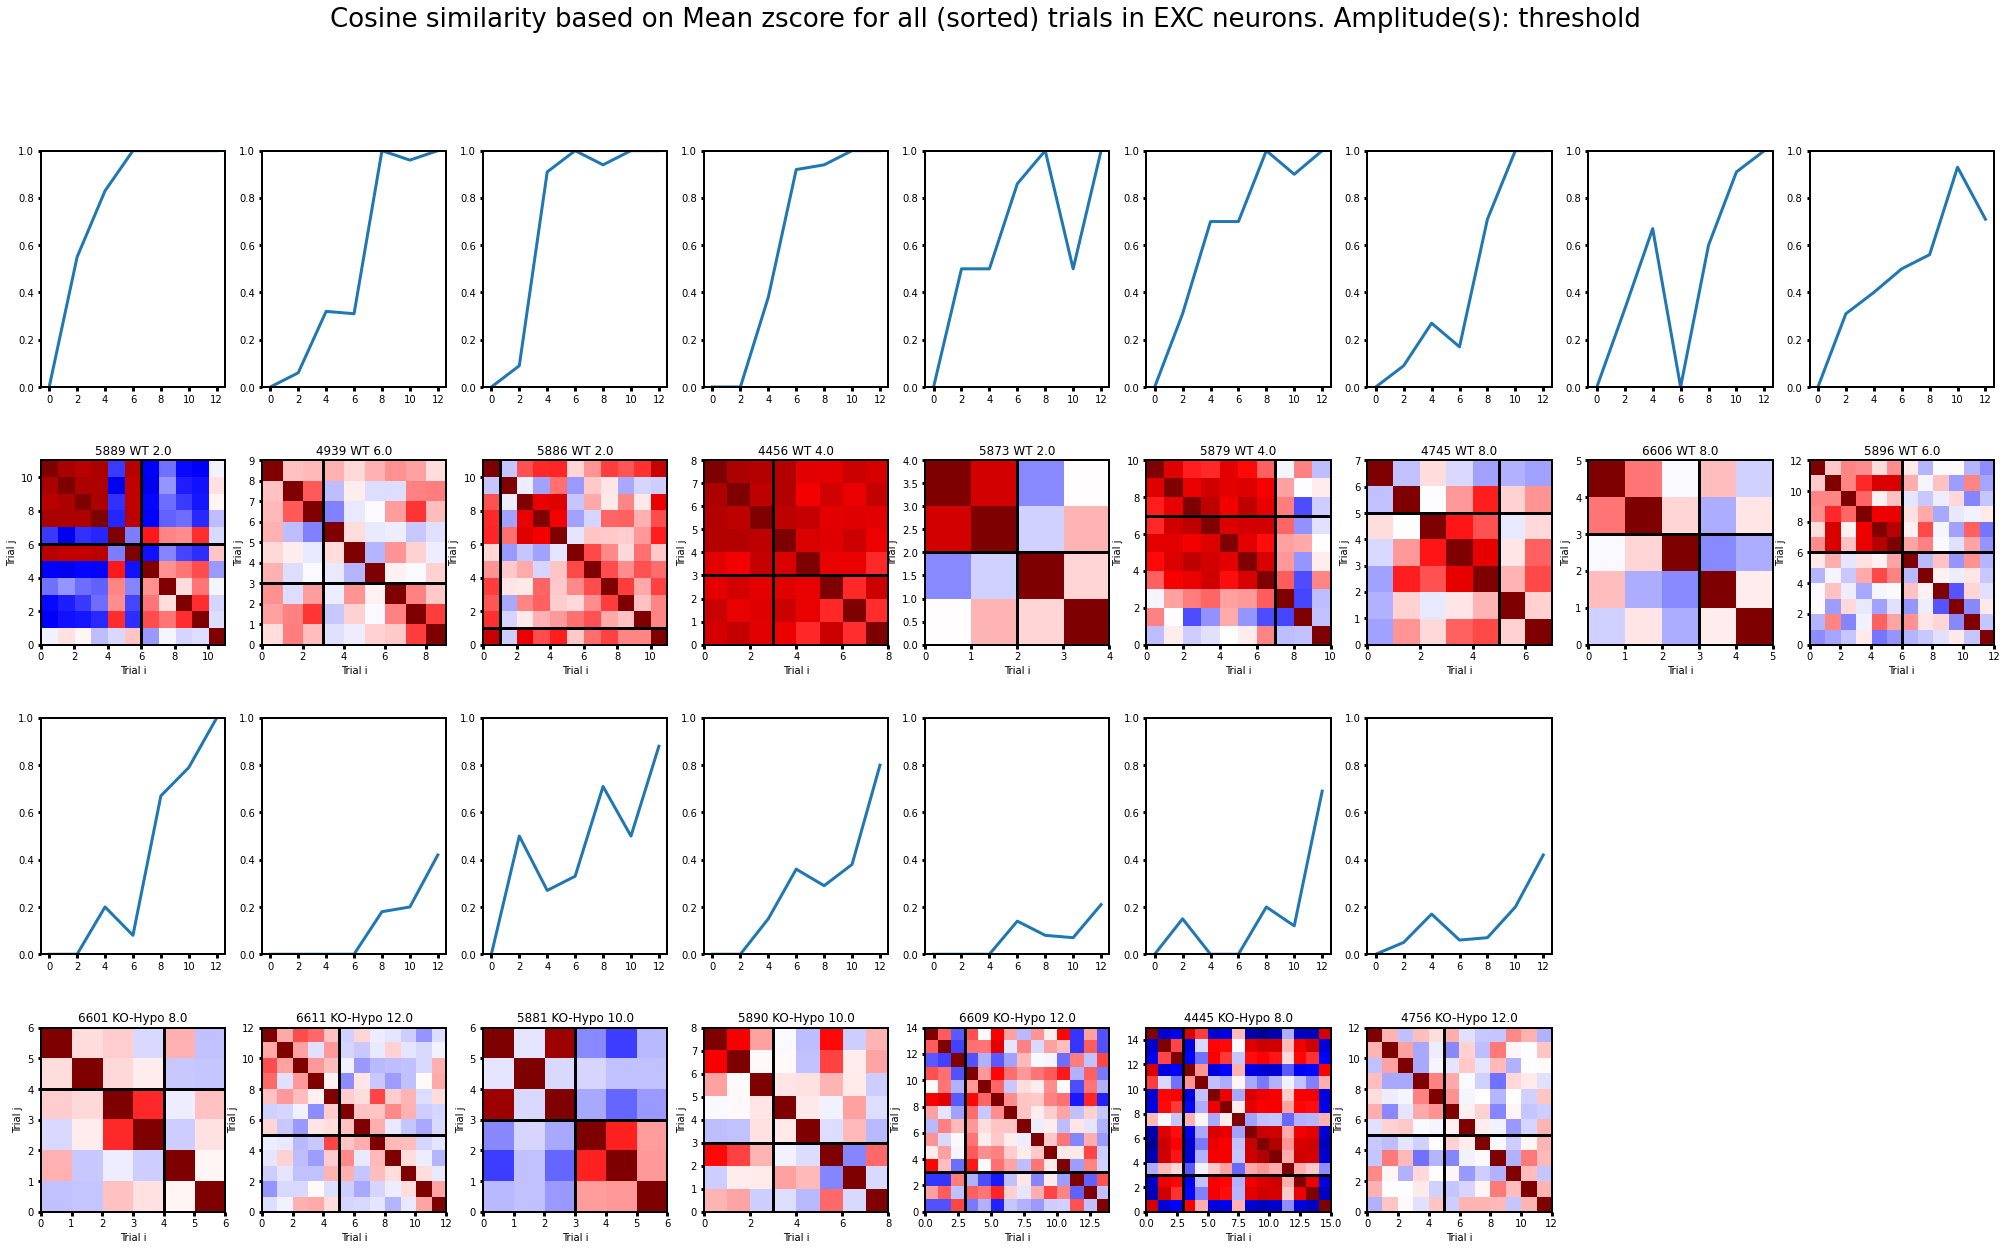

In [62]:
plot_cosine_similarity(recs, "zscore", estimator="Mean", exc_neurons=True, inh_neurons=False, detected_trials=True, undetected_trials=True, stim_ampl="threshold", det_sorting=True)

### Detected trials

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


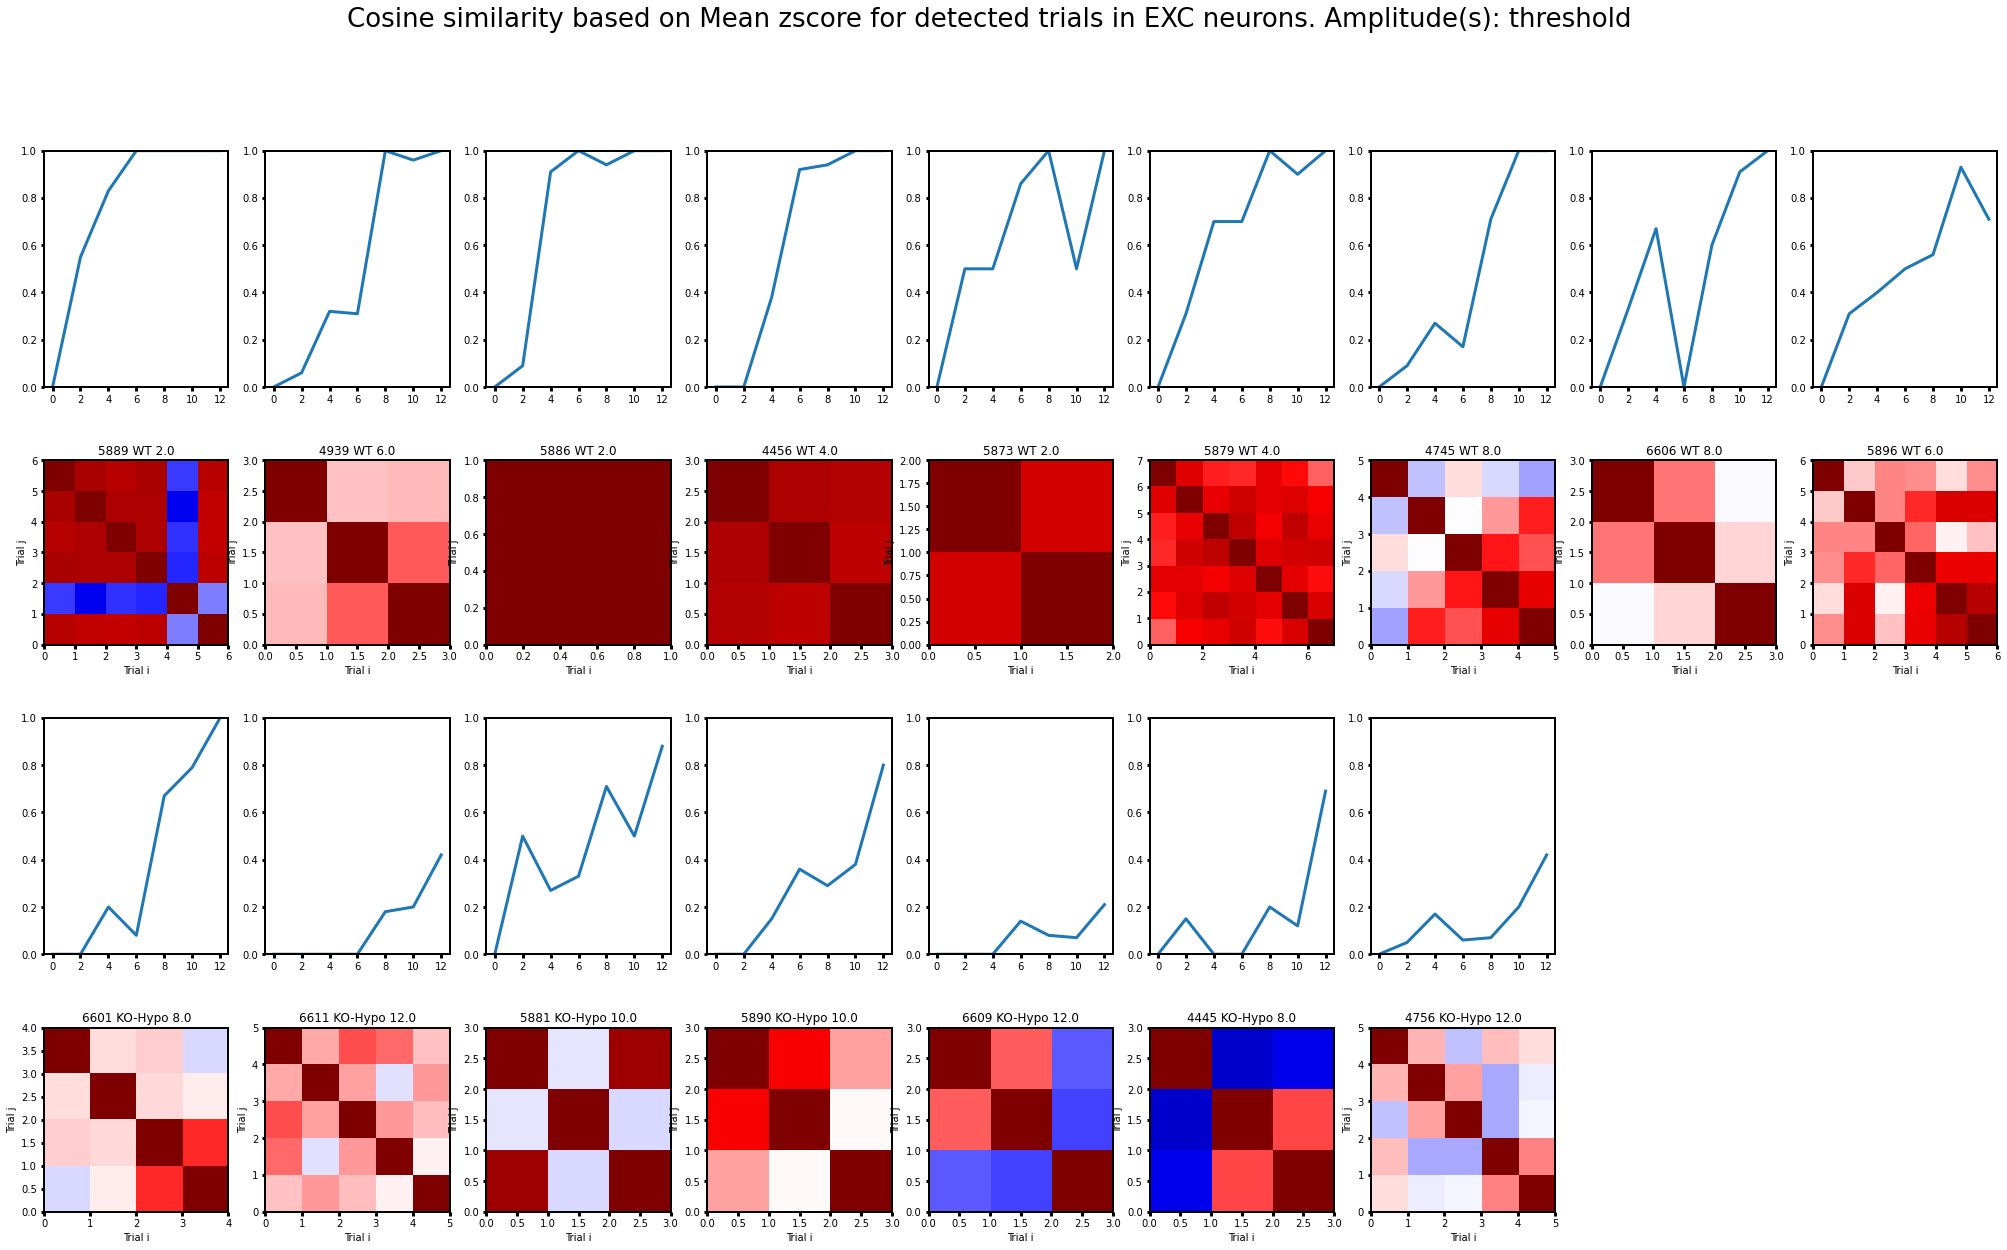

In [63]:
plot_cosine_similarity(recs, "zscore", estimator="Mean", exc_neurons=True, inh_neurons=False, detected_trials=True, undetected_trials=False, stim_ampl="threshold")

### Undetected trials

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


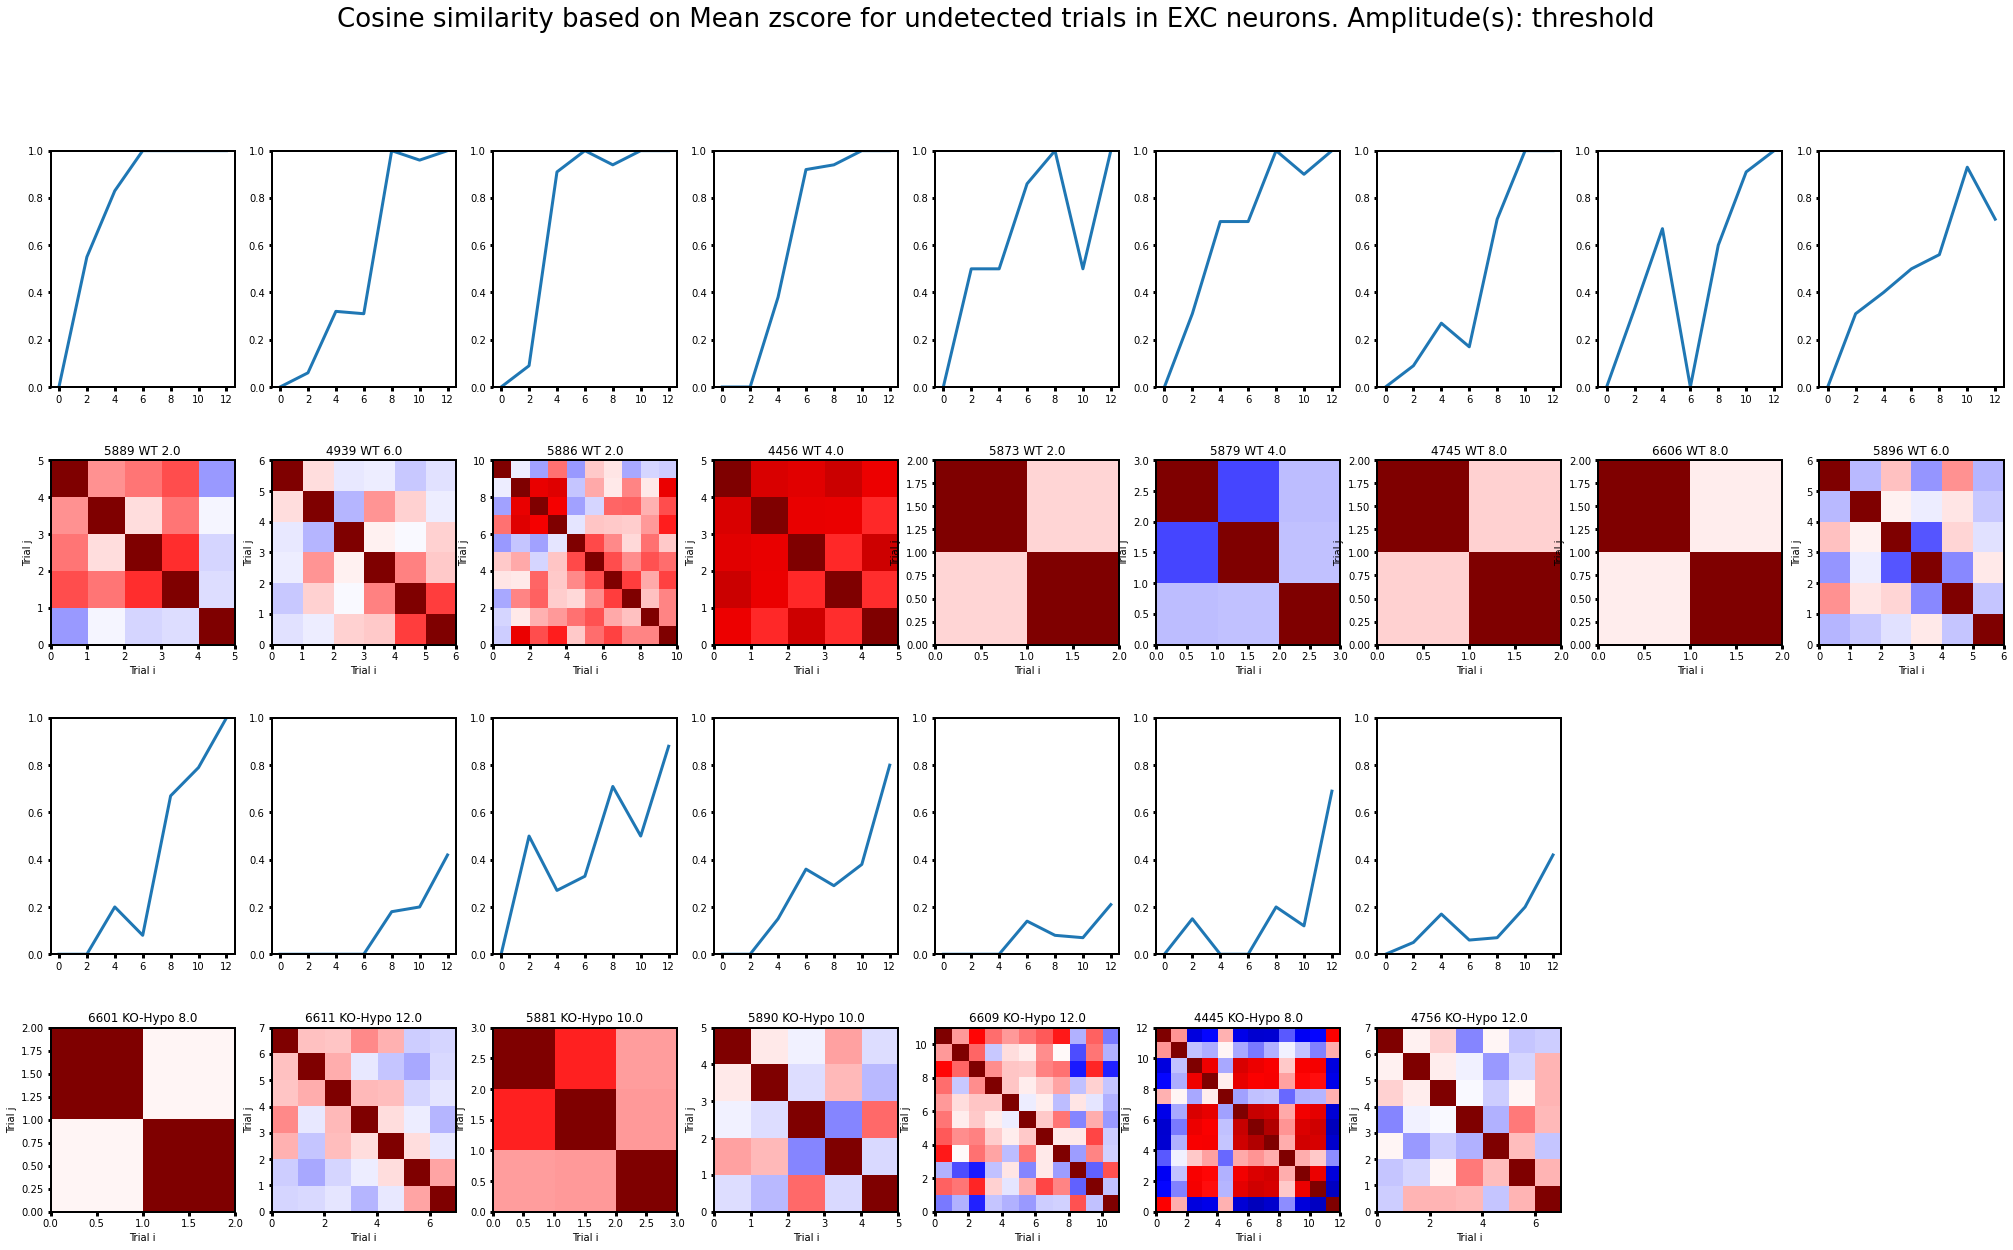

In [64]:
plot_cosine_similarity(recs, "zscore", estimator="Mean", exc_neurons=True, inh_neurons=False, detected_trials=False, undetected_trials=True, stim_ampl="threshold")

# Cosine similarity based on std of zscore

---

## All amplitudes

### All trials

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


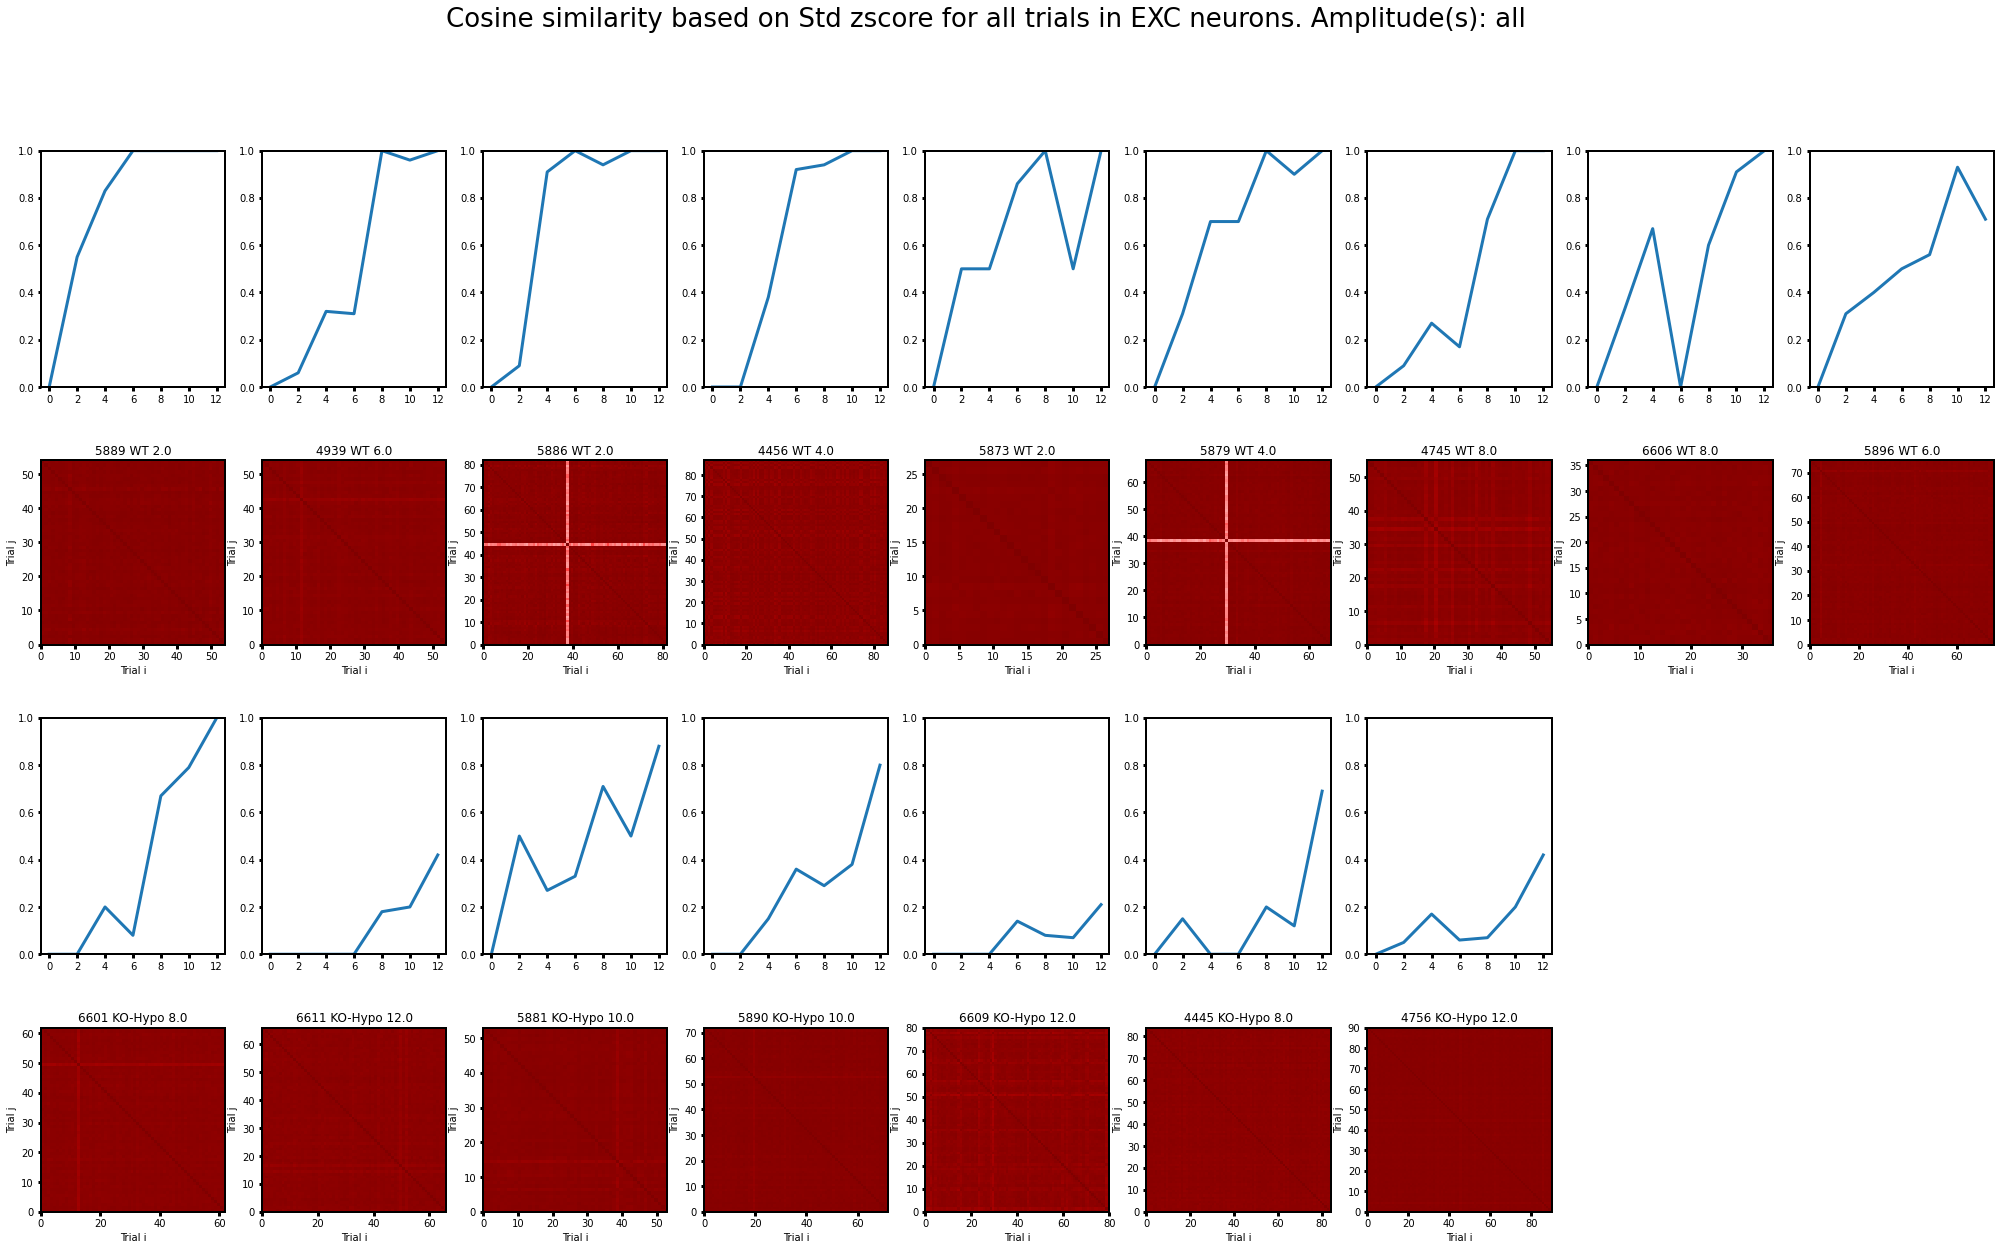

In [65]:
plot_cosine_similarity(recs, "zscore", estimator="Std", exc_neurons=True, inh_neurons=False, detected_trials=True, undetected_trials=True, stim_ampl="all")

# Group comparison using cosine similarity

---

We will use cosine similarity based on mean zscore at threshold amplitude to compare groups

In [66]:
def get_mean_cosine_similarity(rec, parameter, estimator=None, exc_neurons=True, inh_neurons=False, detected_trials=True, undetected_trials=True, stim_ampl="all"):
    # Filtering stimulation amplitudes
    stim_filter = rec.stim_ampl_filter(stim_ampl)
    
    # Retrieving data for specified parameter and neuron type
    if parameter == "zscore":
        para_mat = get_zscore_estimator(rec, estimator, exc_neurons=exc_neurons, inh_neurons=inh_neurons).T
    else:
        # Filtering neuron type
        if exc_neurons and inh_neurons: 
            para_mat = np.row_stack((rec.matrices["EXC"][parameter], rec.matrices["INH"][parameter]))
        elif exc_neurons:
            para_mat = rec.matrices["EXC"][parameter]
        elif inh_neurons:
            para_mat = rec.matrices["INH"][parameter]
    
    # Filtering detected trials and amplitudes
    if detected_trials and undetected_trials:
        filt_para_mat = para_mat.T[stim_filter]
    elif detected_trials:
        filt_para_mat = para_mat.T[np.logical_and(rec.detected_stim, stim_filter)]
    elif undetected_trials:
        filt_para_mat = para_mat.T[np.logical_and(np.invert(rec.detected_stim), stim_filter)]

    return np.mean(cosine_similarity(filt_para_mat))

5889
6601
4939
5893
5886
4456
6611
5873
5881
5879
4754
5890
4745
6606
6609
5896
4445
4756
Boxplot plotting.
--- Mean cosine similarity ---
ShapiroResult(statistic=0.8833381533622742, pvalue=0.17019681632518768)
ShapiroResult(statistic=0.9263924360275269, pvalue=0.5206522941589355)
LeveneResult(statistic=0.7324060063578092, pvalue=0.4065136324646669)
Equal variances :Ttest_indResult(statistic=2.647536121787969, pvalue=0.019120884381374742)


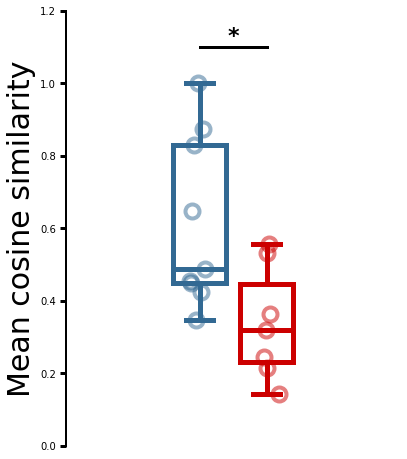

In [67]:
cos_sim_wt = []
cos_sim_ko = []
for rec in recs.values():
    print(rec.filename)
    mean_cos_sim = get_mean_cosine_similarity(rec, "zscore", estimator="Mean", exc_neurons=True, inh_neurons=True, detected_trials=True, undetected_trials=False, stim_ampl="threshold")
    
    if rec.genotype == "WT":
        cos_sim_wt.append(mean_cos_sim)
    elif rec.genotype == "KO-Hypo":
        cos_sim_ko.append(mean_cos_sim)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 8))
ax.set_facecolor("white")
st.boxplot(ax, cos_sim_wt, cos_sim_ko, "Mean cosine similarity", ylim=[0, 1.1])